In [ ]:
##################Kasper1
import scipy.linalg as lin
import numpy as np
import itertools
import time
import sys
import math
import re
import csv
import pandas as pd

#Assume the first r rows of a forms an orthonormal basis
#Returns the projection of x onto the orthogonal complement of the rows of a
#scaled to unit length
def make_orthogonal(a,r,x):
    if np.linalg.norm(x)<1e-8:
        return None
    if r==0:
        return x/np.linalg.norm(x)
    u = x
    for j in range(0,int(r/100)):
        u = u - a[range(j*100,(j+1)*100)].T @ (a[range(j*100,(j+1)*100)] @ u)
    for j in range(int(r/100)*100,r):
        u = u - np.inner(u,a[j]) * a[j]
    norm = np.linalg.norm(u)
    if norm < np.linalg.norm(x)/100:
        return None
    u = u/norm
    return u

def round_coloring(a,x,norm = np.inf, balanced=False):
    start = time.time()
    n = a.shape[1]
    abs = np.absolute(x)
    live = (abs < 1.0-1e-4)
    #first sample each entry
    samples = np.random.random_sample(n)
    signs = np.ones(n)
    signs[samples < (1.0-abs)/2.0] = -1
    flipped = np.multiply(x,signs)
    y = np.sign(flipped)
    y[y==0]=1
    #then try all assignments to the coordinates that were live
    num_live = sum(live)
    if num_live<=10:
        live_indices = [i for i, x in enumerate(live) if x]
        ay = a@y
        sub_a = a[:,live_indices]
        sub_y = y[live_indices]
        sub_ay = sub_a @ sub_y
        a_outside = ay - sub_ay
        best_sub_y = sub_y
        best_norm = np.linalg.norm(ay,ord=norm)
        sign_flips = np.ones(num_live)
        while True:
            at = 0
            while at<num_live and sign_flips[at]==-1:
                sign_flips[at]=1
                at = at+1
            if at==num_live:
                break
            sign_flips[at]=-1
            new_sub_y = np.multiply(sub_y,sign_flips)
            new_sub_ay = sub_a @ new_sub_y
            new_ay = a_outside + new_sub_ay
            new_norm = np.linalg.norm(new_ay,ord=norm)
            if new_norm < best_norm:
                best_norm = new_norm
                best_sub_y = new_sub_y
        y[live_indices] = best_sub_y
    #balance the vector in case we need to
    if balanced:
        while True:
            toFlip = 1
            if sum(y==1) < n/2:
                toFlip = -1
            ofToFlip = sum(y==toFlip)
            needToFlip = int(ofToFlip-n/2)
            if needToFlip==0:
                break
            listOfToFlip = [i for i, x in enumerate(y) if x==toFlip]
            ay = a @ y
            best_norm = 1e27
            #try all single flips
            best_to_flip = 0
            for i in listOfToFlip:
                col = a[:,i]
                new_ay = ay - (2*col*y[i])
                new_norm = np.linalg.norm(new_ay,ord=norm)
                if new_norm < best_norm:
                    best_norm = new_norm
                    best_to_flip = i
            y[best_to_flip] = -y[best_to_flip]
    return y

def to_square(a,x,balanced=False):
    n = a.shape[1]
    m = a.shape[0]
    if n<=m:
        return x
    live = n
    orth = np.zeros((n,n))
    is_live = np.ones(n)
    num_orth = 0
    for i in range(0,m):
        p = make_orthogonal(orth,num_orth,a[i])
        if not p is None:
            orth[num_orth] = p
            num_orth = num_orth + 1
    if balanced:
        all_ones = np.ones(n)
        p = make_orthogonal(orth,num_orth,all_ones)
        if np.linalg.norm(p) > 0.01:
            orth[num_orth] = p
            num_orth = num_orth + 1
    while num_orth < n and sum(is_live) > 8:
        #sample a random vector
        g = np.random.randn(n)
        #make it orthogonal to all in orth
        gamma = make_orthogonal(orth,num_orth,g)
        if gamma is None:
            break
        #set all that are not live to 0 for numerical stability
        for i in range(0,n):
            if not is_live[i]:
                gamma[i] = 0
        #find coord that freezes first
        delta = 1e30
        for i in range(0,n):
            if is_live[i] and abs(gamma[i]) > 1e-7:
                dist = 0
                if gamma[i] * x[i] >= 0:
                    dist = (1-abs(x[i]))/abs(gamma[i])
                else:
                    dist = (1+abs(x[i]))/abs(gamma[i])
                if dist < delta:
                    delta = dist
        if delta > 1e25:
            break
        x = x + delta * gamma
        for i in range(0,n):
            if is_live[i] and abs(x[i]) >= 1-1e-6:
                is_live[i] = 0
                e = np.zeros(n)
                e[i] = 1
                p = make_orthogonal(orth,num_orth,e)
                if not p is None:
                    orth[num_orth] = p
                    num_orth = num_orth+1
                    if num_orth>=n:
                        break
    return x

def partial_color(a,x,norm=np.inf,balanced=False):
    if norm==np.inf:
        return partial_infty_color(a,x,balanced)
    if norm==2:
        return partial_l2_color(a,x,balanced)

def partial_l2_color(a, x, balanced=False):
    n = a.shape[1]
    m = a.shape[0]
    delta=1e-5

    #count number of live coordinates
    abs_x = np.absolute(x)
    is_live = (abs_x < 1.0-delta)
    initial_is_live = is_live.copy()
    live = is_live.sum()
    if live<8: 
        return True
    initial_live=live
    #extract the live coordinates and columns
    y = x[initial_is_live]
    b = a[:,initial_is_live]
    #compute eigenvectors of bTb
    bTb = b.T @ b
    w, v = lin.eigh(bTb)
    num_iters = 0
    was_live = np.ones(initial_live,dtype=bool)
    num_frozen = 0
    orth = np.zeros((initial_live,initial_live))
    num_orth = 0
    to_add = v[:,range(initial_live-int(initial_live/2), initial_live)].T
    orth[range(0,to_add.shape[0])] = to_add
    num_orth = to_add.shape[0]
    if balanced:
        ones = np.ones(initial_live)
        ones = make_orthogonal(orth,num_orth,ones)
        if not ones is None:
            orth[num_orth] = ones
            num_orth = num_orth+1
    while int((live*3/2)) > initial_live:
        #will have at most 1/3 * initial_live that are frozen
        abs_y = np.absolute(y)
        #start by freezing new frozen coordinates
        is_live = (abs_y < 1.0-delta)
        diff = is_live!=was_live
        num_diff = diff.sum()
        if num_diff>0:
            for i in range(0,initial_live):
                if diff[i]:
                    e = np.zeros(initial_live)
                    e[i] = 1
                    p = make_orthogonal(orth,num_orth,e)
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_frozen = num_frozen + 1
            was_live = is_live
        if num_orth>=initial_live:
            break
        num_iters = num_iters+1
        ax = a @ x
        #sample a random vector
        g = np.random.randn(initial_live)
        #make it orthogonal to all in orth
        gamma = make_orthogonal(orth,num_orth,g)
        if gamma is None:
            break
        #set coords to zero where not live, due to numerical stability
        for i in range(0,initial_live):
            if not is_live[i]:
                gamma[i] = 0
        if np.linalg.norm(gamma,ord=np.inf)==0:
            break
        if np.inner(ax,b @ gamma) > 0:
            gamma = -gamma
        coord_mult = np.multiply(gamma,y)
        val = np.where(coord_mult < 0, (1+abs(y))/(1e-27+abs(gamma)), (1-abs(y))/(1e-27 + abs(gamma)))
        val = np.where(is_live, val, 1e27)
        z = min(val)
        y = y + z*gamma
        x[initial_is_live] = y
        new_abs_y = np.absolute(y)
        is_live = (new_abs_y < 1.0-delta)
        live = is_live.sum()
    return False

def partial_infty_color(a, x, balanced=False):
    n = a.shape[1]
    m = a.shape[0]
    delta=1e-5

    #count number of live coordinates
    abs_x = np.absolute(x)
    is_live = (abs_x < 1.0-delta)
    initial_is_live = is_live.copy()
    live = is_live.sum()
    if live<8: 
        return True
    initial_live=live
    #extract the live coordinates and columns
    y = x[initial_is_live]
    b = a[:,initial_is_live]
    num_iters = 0
    was_live = np.ones(initial_live,dtype=bool)
    was_small = np.ones(m,dtype=bool)
    orth = np.zeros((initial_live,initial_live))
    num_orth = 0
    if balanced:
        ones = np.ones(initial_live)
        ones = ones/np.sqrt(initial_live)
        orth[0] = ones
        num_orth = num_orth+1
    num_frozen = 0
    num_big = 0
    num_initial = 0
    while int((live*5)/4) > initial_live:
        #will have at most 1/3 * initial_live that are frozen
        #freeze up to 1/3 largest coords
        abs_y = np.absolute(y)
        #start by freezing new frozen coordinates
        is_live = (abs_y < 1.0-delta)
        diff = is_live!=was_live
        num_diff = diff.sum()
        if num_diff>0:
            for i in range(0,initial_live):
                if diff[i]:
                    e = np.zeros(initial_live)
                    e[i] = 1
                    p = make_orthogonal(orth,num_orth,e)
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_frozen = num_frozen + 1
            was_live = is_live
        if num_orth>=initial_live:
            break
        #may freeze same number of rows based on abs value
        num_iters = num_iters+1
        ax = a @ x
        abs_ax = np.absolute(ax)
        if num_initial < initial_live/4:
            sorted_indices = np.argsort(-abs_ax)
            for i in range(0, m):
                if was_small[sorted_indices[i]]:
                    p = make_orthogonal(orth,num_orth,b[sorted_indices[i]])
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_initial = num_initial + 1
                    was_small[sorted_indices[i]] = False
                    if num_initial >= initial_live/4:
                        break
        if num_orth>=initial_live:
            break
        if num_big < num_frozen:
            sorted_indices = np.argsort(-abs_ax)
            for i in range(0,m):
                if was_small[sorted_indices[i]]:
                    p = make_orthogonal(orth,num_orth,b[sorted_indices[i]])
                    if not p is None:
                        orth[num_orth] = p
                        num_orth = num_orth + 1
                        if num_orth>=initial_live:
                            break
                    num_big = num_big + 1
                    was_small[sorted_indices[i]] = False
                    if num_big >= num_frozen:
                        break
        if num_orth>=initial_live:
            break
        #sample a random vector
        g = np.random.randn(initial_live)
        #make it orthogonal to all in orth
        gamma = make_orthogonal(orth,num_orth,g)
        if gamma is None:
            break
        #set coords to zero where not live, due to numerical stability
        for i in range(0,initial_live):
            if not is_live[i]:
                gamma[i] = 0
        if np.linalg.norm(gamma,ord=np.inf)==0:
            break
        if np.inner(ax,b @ gamma) > 0:
            gamma = -gamma
        coord_mult = np.multiply(gamma,y)
        val = np.where(coord_mult < 0, (1+abs(y))/(1e-27+abs(gamma)), (1-abs(y))/(1e-27 + abs(gamma)))
        val = np.where(is_live, val, 1e27)
        z = min(val)
        y = y + z*gamma
        x[initial_is_live] = y
        new_abs_y = np.absolute(y)
        is_live = (new_abs_y < 1.0-delta)
        live = is_live.sum()
    return False


def local_improvements(a,x,time_limit,norm=np.inf, balanced=False):
    ax = a @ x
    best_norm = np.linalg.norm(ax,ord=norm)
    start_time = time.time()
    num_flip = min(7,len(x))
    if balanced and num_flip%2==1:
        num_flip = num_flip + 1
    iters = 0
    while True:
        iters = iters+1
        #Try flipping random coords
        for iteration in range(0,a.shape[1]):
            sampled_coords = np.random.randint(0,a.shape[1],num_flip)
            sampled_coords = np.sort(sampled_coords)
            allDistinct=True
            for i in range(0,num_flip-1):
                if sampled_coords[i]==sampled_coords[i+1]:
                    allDistinct=False
            if not allDistinct:
                continue
            if balanced:
                #check equal num of +1 and -1
                sum_is=0
                for i in range(0,num_flip):
                    sum_is = sum_is + x[sampled_coords[i]]
                if sum_is!=0:
                    continue
            subcols = a[:,sampled_coords]
            subx = [x[index] for index in sampled_coords]
            bx = ax - 2*(subcols @ subx)
            the_norm = np.linalg.norm(bx,ord=norm)
            if the_norm<best_norm:
                best_norm = the_norm
                for i in sampled_coords:
                    x[i] = -x[i]
                ax = bx
        if time.time()-start_time > time_limit:
            break 
    return x

def basic_local_search(a,x,norm,balanced=False):
    ax = a@x
    best_norm = np.linalg.norm(ax,ord=norm)
    improved=True
    while improved:
        improved=False
        #Try flipping single coords
        for i in range(0,a.shape[1]):
            flipped = ax - 2*x[i]*a[:,i]
            if np.linalg.norm(flipped, ord=norm) < best_norm:
                if balanced:
                    #must find one to swap with
                    for j in range(0,a.shape[1]):
                        if x[i]==x[j]:
                            continue
                        final_flipped = flipped - 2*x[j]*a[:,j]
                        if np.linalg.norm(final_flipped,ord=norm) < best_norm:
                            ax = final_flipped
                            x[i] = -x[i]
                            x[j] = -x[j]
                            best_norm = np.linalg.norm(final_flipped,ord=norm)
                            improved=True
                            break
                else:
                    ax = flipped
                    x[i] = -x[i]
                    best_norm = np.linalg.norm(flipped,ord=norm)
                    improved=True
    return x

def greedy(a,norm,balanced=False):
    x = np.zeros(a.shape[1])
    if balanced:
        so_far = np.zeros(a.shape[0])
        for i in range(0,a.shape[1]):
            if i%2==1:
                continue
            test = so_far + a[:,i]
            test_minus = so_far - a[:,i]
            if i<a.shape[1]-1:
                test = test - a[:,i+1]
                test_minus = test_minus + a[:,i+1]
            if np.linalg.norm(test,ord=norm) < np.linalg.norm(test_minus,ord=norm):
                x[i] = 1
                if i<a.shape[1]-1:
                    x[i+1]=-1
            else:
                x[i] = -1
                if i<a.shape[1]-1:
                    x[i+1] = 1
    else:
        x[0] = 1
        so_far = a[:,0]
        for i in range(1,a.shape[1]):
            test = so_far + a[:,i]
            test_minus = so_far - a[:,i]
            if np.linalg.norm(test,ord=norm) <  np.linalg.norm(test_minus,ord=norm):
                x[i] = 1
            else:
                x[i] = -1
            so_far = so_far + x[i]*a[:,i]
    return x

def discrepancy_minimize(a, norm=np.inf, balanced=False, local_search=0.3):
    n = a.shape[1]
    x = np.zeros(n)
    start_time = time.time()
    x = to_square(a,x,balanced)
    while not partial_color(a,x, norm, balanced):
        pass
    end_time = time.time()
    elapsed = end_time - start_time
    y = round_coloring(a,x,norm, balanced)
    y = basic_local_search(a,y,norm,balanced)
    #check if greedy approach is better
    g = greedy(a,norm,balanced)
    g = basic_local_search(a,g,norm,balanced)
    if np.linalg.norm(a@g,ord=norm) < np.linalg.norm(a@y, ord=norm):
        y = g
    y = local_improvements(a,y, elapsed*local_search, norm, balanced)
    y = basic_local_search(a,y,norm,balanced)
    total_elapsed = time.time()-start_time
    #make sure we return an int array, not floating
    z = np.zeros(n)
    for i in range(n):
        if y[i]==-1:
            z[i]=-1
        else:
            z[i]=1
    return z

def Com(a):
    n = a.shape[0]
    b = np.zeros(n)
    for i in range(n):
        if a[i] == 1:
            b[i]= 0
        else:
            b[i]= 1
    return b   

#python

def FindDisc(a, v):
    n = a.shape[1]
    m = a.shape[0]
    disc = 0
    for i in range(m):
        newdisc = 0
        for j in range(n):
            newdisc = newdisc + v[j]
            #print(newdisc)
        modisc = abs(newdisc)
        if modisc >= disc:
            disc = modisc
    return disc



In [ ]:
#######################kasper2################
def synthetic(data):

    x1=data[0:1399,2]
    n=1400
    R = np.zeros((2, n), dtype = int)
    for i in range(0):
        if x1[i]== 1:
            R[0][i]= 1
        else:
            R[1][i]= 1
    m=2
    n=1400 
    Synth_kasper = discrepancy_minimize(R, norm=np.inf, balanced=False, local_search=0.3)
    r = FindDisc(R,Synth_kasper)
    i=0
    print(r)
    ##############################################
    Synth1={}
    Synth2={}
    for i in range(Synth_kasper.shape[0]):
        if Synth_kasper[i]==1:
            Synth1[i]=1
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1

    Synthu1=Synth1   
    Synthu2=Synth2  
    # germanu1=german1[0:698]
    
    print(r,math.sqrt(n*math.log2(m)))

    return Synthu1,Synthu2,R

In [ ]:
##################3ALL Fair#################3
from random import *
def fair(x,a,b,alpha,R):
    #x-actual a=kesper b=classifier
    
    a_acc=0
    b_acc=0
    f_acc=0
    n= x.shape[0]
    f= np.zeros(n) 
    count=0
    acc=0
    for i in range(n):
        z=random()
        if z < alpha:
            f[i]= a[i] 
            count=count+1
        else:
            f[i]= b[i]
            
    for i in range(n):
         if a[i] == x[i]:
                a_acc=a_acc+1
    for i in range(n):
         if b[i] == x[i]:
                b_acc=b_acc+1
    for i in range(n):
         if f[i] == x[i]:
                f_acc=f_acc+1

    a_acc_percent=a_acc/n            
    b_acc_percent=b_acc/n  
    f_acc_percent=f_acc/n  
     
#     count1=0
#     count2=0
#     for i in range(R.shape[1]):
#         if(R[0,i]==1):
#             if f[i]==1:
#                   count1+=1
#         else:
#             if f[i]==1:
#                 count2+=1
    count1=1
    count2=1
    ratio=float(count1/count2)  
#############################################################
    #     print(f)
#     print(x)
#     print(b)
#     print(a_acc_percent,b_acc_percent)
      
   
    #kasper svm final ratio
    return a_acc_percent,b_acc_percent,f_acc_percent,ratio
        

In [ ]:
import matplotlib.pyplot as plt
def ploting(y_train,u1,y_1,R):
    alpha1_l=[]
    c1_l=[]
    ratio_l=[]
    
    ####### plot################   
    for alpha in [0,0.1, 0.2, 0.3 ,0.4,0.5, 0.6,0.7,0.8,0.9,1]:
        a,b,c,ratio  = fair(y_train,u1,y_1,alpha,R)
        ratio_l.append(ratio)
        alpha1_l.append(alpha)
        c1_l.append(c)
    print(c1_l)
    plt.plot( alpha1_l, c1_l, 'ro')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Fairness(Alpha)')
    plt.ylabel('Train Accuracy')
    plt.title('Accuracy V/S Fairness tradeoff for ProPublica dataset')
    alpha = np.linspace(0, 1, 10) 
    y = alpha*(min(c1_l) - max(c1_l)) + max(c1_l)
    # fig = plt.figure(figsize = (10, 5)) 
    plt.plot(alpha, y) 
    plt.legend(["Experimental", "Theoretical"])
    plt.show() 
#   print(min(c1_l) , max(c1_l))
    
    
    
#     print("ratio------------------")
#     alpha1=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#     plt.plot( alpha1, ratio, 'ro')
#     plt.axis([0, 1, 0, 20])
#     plt.xlabel('Fairness(Alpha)')
#     plt.ylabel('Male/Female Ratio')
#     plt.title('Variation of bias w.r.t Fairness')
#     alpha = np.linspace(0, 1, 10)  
#     plt.show() 

    return a,b,c,ratio

In [ ]:
######################preferential synthetic data(disperate impact)################
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

def generate_synthetic_data(plot_data=False):

    """
        Code for generating the synthetic data.
        We will have two non-sensitive features and one sensitive feature.
        A sensitive feature value of 0.0 means the example is considered to be in protected group (e.g., female) and 1.0 means it's in non-protected group (e.g., male).
    """

    n_samples = 2000 # generate these many data points per class
    disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination

    def gen_gaussian(mean_in, cov_in, class_label):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(n_samples)
        y = np.ones(n_samples, dtype=float) * class_label
        return nv,X,y

    """ Generate the non-sensitive features randomly """
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1) # positive class
    nv2, X2, y2 = gen_gaussian(mu2, sigma2, -1) # negative class

    # join the posisitve and negative class clusters
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))
    
    # shuffle the data
    perm = [*range(0,n_samples*2)]

    shuffle(perm)
    X = X[perm]
    y = y[perm]
    
    rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
    X_aux = np.dot(X, rotation_mult)


    """ Generate the sensitive feature here """
    x_control = [] # this array holds the sensitive feature value
    for i in range (0, len(X)):
        x = X_aux[i]

        # probability for each cluster that the point belongs to it
        p1 = nv1.pdf(x)
        p2 = nv2.pdf(x)
        
        # normalize the probabilities from 0 to 1
        s = p1+p2
        p1 = p1/s
        p2 = p2/s
        
        r = np.random.uniform() # generate a random number from 0 to 1

        if r < p1: # the first cluster is the positive class
            x_control.append(1.0) # 1.0 means its male
        else:
            x_control.append(0.0) # 0.0 -> female

    x_control = np.array(x_control)

    """ Show the data """
    if plot_data:
        num_to_draw = 200 # we will only draw a small number of points to avoid clutter
        x_draw = X[:num_to_draw]
        y_draw = y[:num_to_draw]
        x_control_draw = x_control[:num_to_draw]

        X_s_0 = x_draw[x_control_draw == 0.0]
        X_s_1 = x_draw[x_control_draw == 1.0]
        y_s_0 = y_draw[x_control_draw == 0.0]
        y_s_1 = y_draw[x_control_draw == 1.0]
        plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=30, linewidth=1.5, label= "Prot. +ve")
        plt.scatter(X_s_0[y_s_0==-1.0][:, 0], X_s_0[y_s_0==-1.0][:, 1], color='red', marker='x', s=30, linewidth=1.5, label = "Prot. -ve")
        plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=30, label = "Non-prot. +ve")
        plt.scatter(X_s_1[y_s_1==-1.0][:, 0], X_s_1[y_s_1==-1.0][:, 1], color='red', marker='o', facecolors='none', s=30, label = "Non-prot. -ve")

        
        plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
        plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
        plt.legend(loc=2, fontsize=15)
        plt.xlim((-15,10))
        plt.ylim((-10,15))
#         plt.show()
#       plt.savefig("img/data.png")
        
#     x_control = {"s1": x_control} # all the sensitive features are stored in a dictionary
    return X,y,x_control

def Synth_data():
    X,y,x_control=generate_synthetic_data(True)
    X=np.column_stack((X,x_control))
#     print(X)
    return(X,y)








In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%pylab inline
from random import *
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
def Synth_svm(data,label):
   
    X = data
    y = label
    print(y)



    #Split data into training and test datasets (training will be based on 70% of data)
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,shuffle=False) 
    #test_size: if integer, number of examples into test dataset; if between 0.0 and 1.0, means proportion
    print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))


    #Scaling data
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score

    sc = StandardScaler(with_mean=False)
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    #X_train_std and X_test_std are the scaled datasets to be used in algorithms

    #Applying SVC (Support Vector Classification)
    from sklearn.svm import SVC

    svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
    svm.fit(X_train_std, y_train)
    print('The accuracy of the SVM classifier on training data is {:.2f}'.format(svm.score(X_train_std, y_train)))
    print('The accuracy of the SVM classifier on test data is {:.2f}'.format(svm.score(X_test_std, y_test)))
    print('####Train prediction Label###############################################')
    y_1=svm.predict(X_train_std)
    print(y_1)

    # print(y_1[2:3])
    # print(y_1[3:4])
    # print(y_1[4:5])
    # for i in range(X_train.shape[0]):
    #      print(y_1[i])


    print('####Actual Train Label###############################################')
    # print(y_train)

    # y_train.to_numpy()

    # for i in range(X_train.shape[0]):
    #     print(y_train[i])

    ###############################################
    print('####Change to colors###############################################')
    count=0
    for i in range(X_train.shape[0]):
        if y_1[i] == y_train[i]:
            count=count+1
    # print(count)    

    # y_trainx=np.zeros((1,X_train.shape[0]),dtype= int)

    # for i in range(X_train.shape[0]):
    #     if y_train[i]==1:
    #         y_trainx[i]=-1
    #     else:
    #         y_trainx[i]=1



    # for i in range(X_train.shape[0]):
    #     if y_1[i]==1:
    #         y_1x[i]=-1
    #     else:
    #         y_1x[i]=1



    # print('####Test###############################################')
    # y_2=svm.predict(X_test_std)
    return y_1,y_train

In [ ]:
# ##################################################################
# ############lp no epsilon/optimal epsilon
# ##################################################################
# ##PROPUBLICA MIN Max COMMAND 
# import pandas as pd
# import numpy as np
# import pulp as p 
# def min_max_lp_all(data,eps):       
#         x1 = np.zeros((1, 1400), dtype = float)
#         x1=data[0:1400,2]
#         print(x1.shape[0])

#         n=1400
#         R = np.zeros((2, n), dtype = int)
#         for i in range(n):
#             if x1[i]== 1:
#                 R[0][i]= 1
#             else:
#                 R[1][i]= 1
#         m=2
#         n=1400 
        
#         # Create a LP Minimization problem 
#         Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
# #       print(range(n)) 
#         #X[n]=z() n last value of X
                
#         X=np.zeros(n+1,dtype=p.LpVariable)
#         #X[]=0 to n-1

#         for i in range(n):
#             var=str(i)
#             X[i]=p.LpVariable(var,0,1,cat='Integer')
#         X[n] =  p.LpVariable("z",lowBound=0)

#         #########objective function#####################
#         Lp_prob += X[n] 

#         ###############################################

#         ##############constraint#################
#         for i in range(2*m):
#             if i<m:
#                 Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*R[i][j] for j in range(n)])
#             else:        
#                 Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*R[i-m][j] for j in range(n)])

# #         Lp_prob += X[n] >= 0.001*n
# #         Lp_prob += X[n] <= 0.05*n
          
# #         Lp_prob += X[n] >= eps
# #         Lp_prob += X[n] <=1400
#         #####################################
#         status = Lp_prob.solve()   # Solver 
# #         print(p.LpStatus[status]) 
# #         print("discripency is:")
# #         print(p.value(Lp_prob.objective))  # The solution status 
#         racidivism1={}
#         racidivism2={}
#         # # Printing the final solution
#         print(X)
#         for i in range(n):
#             if(p.value(X[i])==0):
#                 racidivism1[i]=-1 
#                 racidivism2[i]=1
#             else:
#                 racidivism1[i]=1
#                 racidivism2[i]=-1
#         racidivismu1=racidivism1  
#         racidivismu2=racidivism2    
        
   
        
        
         
#         return racidivismu1,racidivismu2,R    
# # print(p.value(Lp_prob.objective))   

# # objectivefn
# # Lp_prob +=  exp

# # # Create problem Variables  
# # x = p.LpVariable("x", lowBound = 0)   # Create a variable x >= 0 
# # y = p.LpVariable("y", lowBound = 0)   # Create a variable y >= 0 
  
# # Objective Function 
# # Lp_prob += 3 * x + 5 * y    
  
# # x="x[0]"

# # # Constraints: 
# # Lp_prob += 2 * x + 3 * y >= 12
# # Lp_prob += -x + y <= 3
# # Lp_prob += x >= 4
# # Lp_prob += y <= 3
# # print(type(Lp_prob)) 
# # # Display the problem 
# # print(Lp_prob) 
  
# # status = Lp_prob.solve()   # Solver 
# # print(p.LpStatus[status])   # The solution status 
  
# # # Prianting the final solution 
# # print(p.value(x), p.value(y), p.value(Lp_prob.objective))   

    

In [ ]:
# #####################-----LP-run--wid alpha-##################3
# import pandas as pd
# import pulp as p 
# import math
# import numpy as np
# import matplotlib.pyplot as plt # for plotting stuff
# from random import seed, shuffle
# from scipy.stats import multivariate_normal # generating synthetic data
# SEED = 1122334455
# seed(SEED) # set the random seed so that the random permutations can be reproduced again
# np.random.seed(SEED)

# data,y=Synth_data()
# # print(data.shape[0])
# # print(data.shape[1])
# y_train,y_1=Synth_svm(data,y)
# eps=0
# u1,u2,R=min_max_lp_all(data,eps)
# a,b,c,d=ploting(y_train,u1,y_1,R)
# a,b,c,d=ploting(y_train,u2,y_1,R)

# count3=0
# count1=0
# count2=0
# for j in range(y_train.shape[0]):
#             if(y_train[j]==1):
#                 count3+=1

# for i in range(y_train.shape[0]):    
#     if y_train[i]==u1[i] and y_train[i]==1 :
#         count1+=1
#     if y_train[i]==u2[i] and y_train[i]==1 :
#         count2+=1
# print(count3)        
# print(count1)
# print(count2)
# count3=0
# count1=0
# count2=0
# for j in range(y_train.shape[0]):
#             if(y_train[j]==-1):
#                 count3+=1

# for i in range(y_train.shape[0]):    
#     if y_train[i]==u1[i] and y_train[i]==-1 :
#         count1+=1
#     if y_train[i]==u2[i] and y_train[i]==-1 :
#         count2+=1
# print(count3)        
# print(count1)
# print(count2)
    

In [ ]:
#####################Kasper-run wid alpha##############

# import pandas as pd
# import pulp as p 
# # import math
# import numpy as np
# import matplotlib.pyplot as plt # for plotting stuff
# from random import seed, shuffle
# from scipy.stats import multivariate_normal # generating synthetic data
# SEED = 1122334455
# seed(SEED) # set the random seed so that the random permutations can be reproduced again
# np.random.seed(SEED)

# data,y=Synth_data()
# # print(data.shape[0])
# # print(data.shape[1])
# y_train,y_1=Synth_svm(data,y)

# u1,u2,R=synthetic(data)
# a,b,c,d=ploting(y_train,u1,y_1,R)

# a,b,c,d=ploting(y_train,u2,y_1,R)



In [ ]:
#####################-----LP-epsilon---##################3
import pandas as pd
import pulp as p 
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
# SEED = 1122334455

# seed(SEED) # set the random seed so that the random permutations can be reproduced again
# np.random.seed(SEED)

data,y=Synth_data()
# print(data.shape[0])
# print(data.shape[1])
y_train,y_1=Synth_svm(data,y)
#####################################################

Ms=0
Mns=0
Fs=0
Fns=0
for j in range(y_train.shape[0]):
        if(data[j][2]==1 and y_train[j]==1):
            Ms+=1       

for j in range(y_train.shape[0]):
        if(data[j][2]==1 and y_train[j]==-1):
            Mns+=1


for j in range(y_train.shape[0]):
        if(data[j][2]==0 and y_train[j]==1):
            Fs+=1       

for j in range(y_train.shape[0]):
        if(data[j][2]==0 and y_train[j]==-1):
            Fns+=1


######################################################
print("actual")
ALL=0
ALL=Ms+Mns+Fs+Fns
print(ALL)
print("total males,female")
M=0
F=0
M=Ms+Mns
F=Fs+Fns
print(M,F)
print("total male select,not select")
print(Ms,Mns)
print("total female select,not select")
print(Fs,Fns)



#####################################################
# a,b,c,d=ploting(y_train,u1,y_1,R)
# a,b,c,d=ploting(y_train,u2,y_1,R)

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]
DI1=[]
DI2=[]
for eps in range(0,1300,100) :
    count1=0
    count2=0
    u1,u2,R=min_max_lp_all(data,eps)
######################################Disp_impact###########
#     c1=0
#     c2=0
#     for j in range(y_train.shape[0]):
#             if(data[j][2]==1 and y_train[j]==-1 and u1[j]==y_train[j]):
#                 c1+=1       

#     for j in range(y_train.shape[0]):
#             if(data[j][2]==1 and y_train[j]==1 and u1[j]==y_train[j]):
#                 c2+=1
#     print(c1,c2)
#     c3=0
#     c4=0
#     for j in range(y_train.shape[0]):
#             if(data[j][2]==0 and y_train[j]==-1 and u1[j]==y_train[j]):
#                 c3+=1       

#     for j in range(y_train.shape[0]):
#             if(data[j][2]==0 and y_train[j]==1 and u1[j]==y_train[j]):
#                 c4+=1
#     print(c3,c4)
    
    
    
#     c1=0
#     c2=0
#     for j in range(y_train.shape[0]):
#             if(data[j][2]==1 and y_train[j]==-1 and u2[j]==y_train[j]):
#                 c1+=1       

#     for j in range(y_train.shape[0]):
#             if(data[j][2]==1 and y_train[j]==1 and u2[j]==y_train[j]):
#                 c2+=1
#     print(c1,c2)
#     c3=0
#     c4=0
#     for j in range(y_train.shape[0]):
#             if(data[j][2]==0 and y_train[j]==-1 and u2[j]==y_train[j]):
#                 c3+=1       

#     for j in range(y_train.shape[0]):
#             if(data[j][2]==0 and y_train[j]==1 and u2[j]==y_train[j]):
#                 c4+=1
#     print(c3,c4)


################################################ 

######################################Disp_impact###########
    c1=0
    c2=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u1[j]==1 ):
                c1+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u1[j]==-1 ):
                c2+=1
    c1=float(c1/M)
    c2=float(c2/M)
    print(c1)
    c3=0
    c4=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u1[j]==1 ):
                c3+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u1[j]==-1 ):
                c4+=1
   
    c3=float(c3/F)
    c4=float(c4/F)
    print(c3)
    
    cx=c1-c3
    DIa=cx
    DI1.append(DIa)
    
    
    c1=0
    c2=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u2[j]==1 ):
                c1+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u2[j]==-1 ):
                c2+=1
    c1=float(c1/M)
    c2=float(c2/M)
    print(c1)
    c3=0
    c4=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u2[j]==1 ):
                c3+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u2[j]==-1 ):
                c4+=1
   
    c3=float(c3/F)
    c4=float(c4/F)
    print(c3)
    cx=c1-c3
    DIb=cx
    DI2.append(DIb)

################################################ 


    
    for j in range(y_train.shape[0]):
            if(y_train[j]==u1[j]):
                count1+=1
    acc1=float(count1/y_train.shape[0])        
       
    for j in range(y_train.shape[0]):
            if(y_train[j]==u2[j]):
                count2+=1
    acc2=float(count2/y_train.shape[0])        
    epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)
    print(acc1,acc2)   
print(acc1_l)     
print(acc2_l)
print("Disparate Impact")
print(DI1)     
print(DI2)
print(epsilon_l)
#     print(y_train.shape[0])
#     count3=0
#     count1=0
#     count2=0
#     for j in range(y_train.shape[0]):
#                 if(y_train[j]==1):
#                     count3+=1
   
#     for i in range(y_train.shape[0]):    
#         if y_train[i]==u1[i] and y_train[i]==1 :
#             count1+=1
#         if y_train[i]==u2[i] and y_train[i]==1 :
#             count2+=1
#     print(count3)        
#     print(count1)
#     print(count2)
#     count3=0
#     count1=0
#     count2=0
#     for j in range(y_train.shape[0]):
#                 if(y_train[j]==-1):
#                     count3+=1
   
#     for i in range(y_train.shape[0]):    
#         if y_train[i]==u1[i] and y_train[i]==-1 :
#             count1+=1
#         if y_train[i]==u2[i] and y_train[i]==-1 :
#             count2+=1
#     print(count3)        
#     print(count1)
#     print(count2)
    
    
    
    
    
    
    
    
 



In [ ]:
#####################-----LP-epsilon---##################3
import pandas as pd
import pulp as p 
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
# SEED = 1122334455

# seed(SEED) # set the random seed so that the random permutations can be reproduced again
# np.random.seed(SEED)

data,y=Synth_data()
# print(data.shape[0])
# print(data.shape[1])
y_train,y_1=Synth_svm(data,y)
#####################################################

Ms=0
Mns=0
Fs=0
Fns=0
for j in range(y_train.shape[0]):
        if(data[j][2]==1 and y_train[j]==1):
            Ms+=1       

for j in range(y_train.shape[0]):
        if(data[j][2]==1 and y_train[j]==-1):
            Mns+=1


for j in range(y_train.shape[0]):
        if(data[j][2]==0 and y_train[j]==1):
            Fs+=1       

for j in range(y_train.shape[0]):
        if(data[j][2]==0 and y_train[j]==-1):
            Fns+=1


######################################################
print("actual")
ALL=0
ALL=Ms+Mns+Fs+Fns
print(ALL)
print("total males,female")
M=0
F=0
M=Ms+Mns
F=Fs+Fns
print(M,F)
print("total male select,not select")
print(Ms,Mns)
print("total female select,not select")
print(Fs,Fns)



#####################################################
# a,b,c,d=ploting(y_train,u1,y_1,R)
# a,b,c,d=ploting(y_train,u2,y_1,R)

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]
DI1=[]
DI2=[]
for eps in range(0,1300,100) :
    count1=0
    count2=0
    u1,u2,R=min_max_lp_all(data,eps)
######################################Disp_impact###########
#     c1=0
#     c2=0
#     for j in range(y_train.shape[0]):
#             if(data[j][2]==1 and y_train[j]==-1 and u1[j]==y_train[j]):
#                 c1+=1       

#     for j in range(y_train.shape[0]):
#             if(data[j][2]==1 and y_train[j]==1 and u1[j]==y_train[j]):
#                 c2+=1
#     print(c1,c2)
#     c3=0
#     c4=0
#     for j in range(y_train.shape[0]):
#             if(data[j][2]==0 and y_train[j]==-1 and u1[j]==y_train[j]):
#                 c3+=1       

#     for j in range(y_train.shape[0]):
#             if(data[j][2]==0 and y_train[j]==1 and u1[j]==y_train[j]):
#                 c4+=1
#     print(c3,c4)
    
    
    
#     c1=0
#     c2=0
#     for j in range(y_train.shape[0]):
#             if(data[j][2]==1 and y_train[j]==-1 and u2[j]==y_train[j]):
#                 c1+=1       

#     for j in range(y_train.shape[0]):
#             if(data[j][2]==1 and y_train[j]==1 and u2[j]==y_train[j]):
#                 c2+=1
#     print(c1,c2)
#     c3=0
#     c4=0
#     for j in range(y_train.shape[0]):
#             if(data[j][2]==0 and y_train[j]==-1 and u2[j]==y_train[j]):
#                 c3+=1       

#     for j in range(y_train.shape[0]):
#             if(data[j][2]==0 and y_train[j]==1 and u2[j]==y_train[j]):
#                 c4+=1
#     print(c3,c4)


################################################ 

######################################Disp_impact###########
    c1=0
    c2=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u1[j]==1 ):
                c1+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u1[j]==-1 ):
                c2+=1
    c1=float(c1/M)
    c2=float(c2/M)
    print(c1)
    c3=0
    c4=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u1[j]==1 ):
                c3+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u1[j]==-1 ):
                c4+=1
   
    c3=float(c3/F)
    c4=float(c4/F)
    print(c3)
    
    cx=c1-c3
    DIa=cx
    DI1.append(DIa)
    
    
    c1=0
    c2=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u2[j]==1 ):
                c1+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==1 and u2[j]==-1 ):
                c2+=1
    c1=float(c1/M)
    c2=float(c2/M)
    print(c1)
    c3=0
    c4=0
    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u2[j]==1 ):
                c3+=1       

    for j in range(y_train.shape[0]):
            if(data[j][2]==0 and u2[j]==-1 ):
                c4+=1
   
    c3=float(c3/F)
    c4=float(c4/F)
    print(c3)
    cx=c1-c3
    DIb=cx
    DI2.append(DIb)

################################################ 


    
    for j in range(y_train.shape[0]):
            if(y_train[j]==u1[j]):
                count1+=1
    acc1=float(count1/y_train.shape[0])        
       
    for j in range(y_train.shape[0]):
            if(y_train[j]==u2[j]):
                count2+=1
    acc2=float(count2/y_train.shape[0])        
    epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)
    print(acc1,acc2)   
print(acc1_l)     
print(acc2_l)
print("Disparate Impact")
print(DI1)     
print(DI2)
print(epsilon_l)
#     print(y_train.shape[0])
#     count3=0
#     count1=0
#     count2=0
#     for j in range(y_train.shape[0]):
#                 if(y_train[j]==1):
#                     count3+=1
   
#     for i in range(y_train.shape[0]):    
#         if y_train[i]==u1[i] and y_train[i]==1 :
#             count1+=1
#         if y_train[i]==u2[i] and y_train[i]==1 :
#             count2+=1
#     print(count3)        
#     print(count1)
#     print(count2)
#     count3=0
#     count1=0
#     count2=0
#     for j in range(y_train.shape[0]):
#                 if(y_train[j]==-1):
#                     count3+=1
   
#     for i in range(y_train.shape[0]):    
#         if y_train[i]==u1[i] and y_train[i]==-1 :
#             count1+=1
#         if y_train[i]==u2[i] and y_train[i]==-1 :
#             count2+=1
#     print(count3)        
#     print(count1)
#     print(count2)
    
    
    
    
    
    
    
    
 



In [ ]:
############################---LP4--with epsilon-with accuracy-########################
#############----Synthetic MIN Max COMMAND----###################### 
def min_max_lp_all(data,eps,r):
    x1 = np.zeros((1, 1400), dtype = float)
    x1=data[0:1400,2]
    print(x1.shape[0])
    
    n=1400
    R = np.zeros((2, n), dtype = int)
    for i in range(n):
        if x1[i]== 1:
            R[0][i]= 1
        else:
            R[1][i]= 1
    m=2
    n=1400 

    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
    print(range(n)) 
    #X[n]=z() n last value of X
    X=np.zeros(n+1,dtype=p.LpVariable)
    Y=np.zeros(n,dtype=p.LpVariable)
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        var2=str(i+n+2)
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
        Y[i]=p.LpVariable(var2,lowBound=0)
        
    X[n] =  p.LpVariable("z1",lowBound=0)
  

    #########objective function#####################
    
    Lp_prob += X[n] + p.lpSum([Y[j] for j in range(n)])

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*R[i][j] for j in range(n)])
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*R[i-m][j] for j in range(n)])
            
    for i in range(2*n):
        if i<n:
            Lp_prob += Y[i] >= X[i]-r[i]
        else:        
            Lp_prob += Y[i-n] >= -1*(X[i-n]-r[i-n])       
    ##### r(y_train values real labels of data)
    
  

    Lp_prob += X[n] >=eps
    Lp_prob += X[n] <=1300
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")
    x=0
    for i in range(n):
        x=x+p.value(Y[j])
        
    w=p.value(X[n])
    print(w) # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
#     print("LP")
#     print((Lp_prob))  
    return Synthu1,Synthu2,R    
 







In [ ]:
#1D-LP3
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()


# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.

# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.

# Second, show the right spine.
epsilon=[0, 100, 200, 300, 400, 500, 600, 700,800]
DI=[0.0014344997182232921, 0.009129566063835193, 0.018351349966699126, 0.027573133869563005, 0.036794917772426855, 0.04601670167529075, 0.05523848557815462, 0.03087248322147651,0]
Accuracy=[0.5028571428571429, 0.4992857142857143, 0.48928571428571427, 0.4878571428571429, 0.4835714285714286, 0.49214285714285716, 0.49642857142857144, 0.5021428571428571, 0.5142857142857142]
p1, = host.plot(epsilon, Accuracy, "b-", label="Accuracy")
p2, = par1.plot(epsilon, DI, "r--", label="Disperate Impact")


host.set_xlim(0, 800)
host.set_ylim(0, 1)
par1.set_ylim(0, .1)

plt.title('Accuracy and Disparate Impact V/S Discrepancy ')


host.set_xlabel("Discrepancy (Epsilon)")
host.set_ylabel("Accuracy")
par1.set_ylabel("Disperate Impact (DI)")


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())


tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)

host.tick_params(axis='x', **tkw)

lines = [p1, p2]

host.legend(lines, [l.get_label() for l in lines],loc='upper left')

plt.show()

In [ ]:
import matplotlib.pyplot as plt


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()


# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.

# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.

# Second, show the right spine.
epsilon=[0, 100, 200, 300, 400, 500, 600, 700,800]
Accuracy=[0.5014285714285714, 0.505, 0.5121428571428571, 0.5178571428571429, 0.5192857142857142, 0.5135714285714286, 0.5235714285714286, 0.5071428571428571, 0.4928571428571429]
DI=[0.0014434209902280393, 0.014494008771875566, 0.029134421672759925, 0.043774834573644394, 0.05841524747452875, 0.07305566037541322, 0.08769607327629758, 0.046692607003890996,0]
p1, = host.plot(epsilon, Accuracy, "b-", label="Accuracy")
p2, = par1.plot(epsilon, DI, "r--", label="Disperate Impact")



host.set_xlim(0, 800)
host.set_ylim(0, 1)
par1.set_ylim(0, .1)

plt.title('Accuracy and Disparate Impact V/S Discrepancy ')
host.set_xlabel("Discrepancy (Epsilon)")
host.set_ylabel("Accuracy")
par1.set_ylabel("Disperate Impact (DI)")


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())


tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)

host.tick_params(axis='x', **tkw)

lines = [p1, p2]

host.legend(lines, [l.get_label() for l in lines],loc='upper left')

plt.show()

In [ ]:
#  5-D Synthetic dataset 

import pulp as p 
import math

 # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal





############################33
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data3 = make_classification(n_samples=2000, n_features=10, n_informative=4, n_redundant=6, n_repeated=0, 
                            n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0.00, class_sep=1.0, 
                            hypercube=True, shift=0.0, scale=1.0, shuffle=False, random_state=10)
df3 = pd.DataFrame(data3[0],columns=['x'+str(i) for i in range(1,11)])
df3['y'] = data3[1]


# print(df3)

df=df3.drop(columns=['x1','x2','x3','x4','x5'])


# print(df)
# df_sensitive=df.copy()

df.head()
DI=np.zeros(5,dtype='float')
DI_f=np.zeros(5,dtype='float')
for j in range(5):  
    a=0
    b=0
    acc1=0
    acc2=0
    for i in range(df.shape[0]): 
       
        if df.iloc[i,j]>=0:
            a=a+1
            df.iloc[i,j]=1
            if df.iloc[i,5]==1 :
                acc1=acc1+1
            
                    
        else:
            b=b+1
            df.iloc[i,j]=0
            if df.iloc[i,5]==1 :
                acc2=acc2+1
    print(acc1)
    print(acc2)
    a1=float(acc1/a)
    b1=float(acc2/b)
    DI[j]=abs(a1-b1)
    print(DI[j])
    
    if (a1>=b1 and a1>0):
            DI_f[j]=float(b1/a1)
    elif (a1<b1 and b1>0) :
            DI_f[j]=float(a1/b1)
    print(DI_f[j])
    
    print(a,b) 
    
# df.head()

data=df.drop(columns=['y'])
r=df.drop(columns=['x6','x7','x8','x9','x10'])


for i in range(data.shape[0]):
    if r.iat[i,0]==1:
         r.iat[i,0]=1            
    else:
         r.iat[i,0]=-1
maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]
DI1=[]
DI2=[]
DI_f1=[]
DI_f2=[]

for eps in range(0,1900,100) :
    count1=0
    count2=0
    u1,u2=min_max_lp_all(data,eps,r)
   ####################################Disp_impact######  
    
    DI=np.zeros(data.shape[1],dtype='float')
    DI_f=np.zeros(data.shape[1],dtype='float')
    for j in range(data.shape[1]):  
        a=0
        b=0
        acc1=0
        acc2=0
        for i in range(data.shape[0]): 

            if df.iloc[i,j]==1:
                a=a+1
              
                if u1[i]==1:
                    acc1=acc1+1


            else:
                b=b+1
                
                if u1[i]==1 :
                    acc2=acc2+1
        a1=float(acc1/a)
        b1=float(acc2/b)
        DI[j]=abs(a1-b1)
        
        if (a1>=b1 and a1>0):
            DI_f[j]=float(b1/a1)
        elif (a1<b1 and b1>0) :
            DI_f[j]=float(a1/b1)
        
            
            
            
           
    #max DI
    DIa=max(DI)
    DIb=sum(DI)/len(DI)
    DI1.append(DIa)
    DI2.append(DIb)
    
    
    DI_fa=max(DI_f)
    DI_fb=sum(DI_f)/len(DI_f)
    DI_f1.append(DI_fa)
    DI_f2.append(DI_fb)
    
    count1=0
    count2=0
    for j in range(r.shape[0]):
            if(r.iat[j,0]==u1[j]):
                count1+=1
    acc1=float(count1/r.shape[0])        
       
    for j in range(r.shape[0]):
            if(r.iat[j,0]==u2[j]):
                count2+=1
    acc2=float(count2/r.shape[0]) 
    
    epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)
    print(acc1,acc2)  
    
print(acc1_l)     
print(acc2_l)

print("Disparate Impact zafar")

print(DI1)     
print(DI2)
print("Disparate Impact feldman")
print(DI_f1)     
print(DI_f2)

print(epsilon_l)

#     print(y_train.shape[0])
#     count3=0
#     count1=0
#     count2=0
#     for j in range(y_train.shape[0]):
#                 if(y_train[j]==1):
#                     count3+=1
   
#     for i in range(y_train.shape[0]):    
#         if y_train[i]==u1[i] and y_train[i]==1 :
#             count1+=1
#         if y_train[i]==u2[i] and y_train[i]==1 :
#             count2+=1
#     print(count3)        
#     print(count1)
#     print(count2)
#     count3=0
#     count1=0
#     count2=0
#     for j in range(y_train.shape[0]):
#                 if(y_train[j]==-1):
#                     count3+=1
   
#     for i in range(y_train.shape[0]):    
#         if y_train[i]==u1[i] and y_train[i]==-1 :
#             count1+=1
#         if y_train[i]==u2[i] and y_train[i]==-1 :
#             count2+=1
#     print(count3)        
#     print(count1)
#     print(count2)
    
    
    
    
    
    
    
    
 




In [ ]:
############################---LP3-with epsilon-with accuracy-########################
#############----Synthetic with 5D MIN Max COMMAND----###################### 

import pulp as p 
def min_max_lp_all(data,eps,r):
    x1=data.transpose()
    x2=np.logical_not(x1).astype(int)
    data1=x1.append(x2)
#   R = np.zeros((2, n), dtype = int)
#     for i in range(n):
#         if x1[i]== 1:
#             R[0][i]= 1
#         else:
    
    
    m=data1.shape[0]
    n=data1.shape[1]
    print(m,n)
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
   
    #X[n]=z() n last value of X
    X=np.zeros(n+1,dtype=p.LpVariable)
    Y=np.zeros(n,dtype=p.LpVariable)
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        var2=str(i+n+2)
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
        Y[i]=p.LpVariable(var2,lowBound=0)
        
    X[n] =  p.LpVariable("z1",lowBound=0)
  

    #########objective function#####################
    
    Lp_prob += X[n] + p.lpSum([Y[j] for j in range(n)])

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*data1.iloc[i,j] for j in range(n)])
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*data1.iloc[i-m,j] for j in range(n)])
            
    for i in range(2*n):
        if i<n:
            Lp_prob += Y[i] >= X[i]-r.iat[i,0]
        else:        
            Lp_prob += Y[i-n] >= -1*(X[i-n]-r.iat[i-n,0])       
    ##### r(y_train values real labels of data)
    
  

    Lp_prob += X[n] >=eps
    Lp_prob += X[n] <=1900
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")
    x=0
    for i in range(n):
        x=x+p.value(Y[j])
        
    w=p.value(X[n])
    print(w) # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
    return Synthu1,Synthu2   

In [ ]:
####5D synthetic LP-3
import matplotlib.pyplot as plt
import numpy as np
Discrepancy=range(0,1900,100)
DI_feld_max=[1.0, 0.8859722244066623, 0.7794339578834946, 0.720059822832381, 0.683489999427994, 0.7274231506044679, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191, 0.6329733697585191]
DI_feld_avg=[0.9982835786441369, 0.7989341715008553, 0.6658177583622219, 0.5724981097989377, 0.4798602043561823, 0.4389818382996548, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908, 0.3531865302756908]

DI_zafar_max=[0.001999396182353008, 0.14965041662675987, 0.2602039429311909, 0.3534113254737071, 0.44920780197573756, 0.5010846833114797, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092, 0.5850988817110092]
DI_zafar_avg=[0.0008588224381351983, 0.10808186475314371, 0.19013380131664231, 0.2557231152696235, 0.32661419259376856, 0.36896519968979385, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966, 0.43779774080542966]

plt.axis([0, 1800, 0, 1])
plt.xlabel('Discripency')
plt.ylabel('Disparate Impact')

plt.title('Disparate Impact V/S Discrepancy for Synthetic-5D sensitive dataset with (LP-3)')


plt.plot(Discrepancy,DI_feld_max)   
plt.plot(Discrepancy,DI_feld_avg)  
plt.plot(Discrepancy,DI_zafar_max)  
plt.plot(Discrepancy,DI_zafar_avg)  

plt.legend(["DI_max_Feldman", "DI_avg_Feldman","DI_max_Zafar", "DI_avg_Zafar"])

plt.show() 







In [ ]:
############################---LP3-with epsilon-with accuracy-########################
#############---- ADULT2 allsens 1 in 1 row MIN Max COMMAND----###################### 
import pandas as pd
import numpy as np
filename = '../input/adult.csv'
d2 = pd.read_csv(filename)
m=d2.shape[1]
n=d2.shape[0]
print(m,n)
x1 = d2.iloc[0:n,8]
x2 = d2.iloc[0:n,9]
y=d2.iloc[0:n,14]
# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if y[i]==' <=50k'or y[i]==' <=50k.':
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((4, n), dtype = int)

a=0
b=0
c=0
d=0
acc1=0
acc2=0
acc3=0
acc4=0
for i in range(n):
    if x1[i] ==' white':
        if x2[i] == ' male':
            data[0][i]= 1
            a=a+1
            if r[i]==1:
                acc1=acc1+1
        else:
            data[1][i]= 1
            b=b+1
            if r[i]==1:
                acc2=acc2+1
            
    else :
        if x2[i] == ' male':
            data[2][i]= 1
            c=c+1
            if r[i]==1:
                acc3=acc3+1
        else:
            data[3][i]= 1
            d=d+1
            if r[i]==1:
                acc4=acc4+1           
print(acc1,acc2)
a1=float(acc1/a)
b1=float(acc2/b)
c1=float(acc3/c)
d1=float(acc4/d)
DI1_feld1=abs(float(b1/a1))
DI1_zafar1=abs(float(b1-a1))
DI1_feld2=abs(float(c1/a1))
DI1_zafar2=abs(float(c1-a1))
DI1_feld3=abs(float(d1/a1))
DI1_zafar3=abs(float(d1-a1))



feld_di_max=max(DI1_feld1,DI1_feld2,DI1_feld3)
zafar_di_max=max(DI1_zafar1,DI1_zafar2,DI1_zafar3)
feld_di_avg= float((DI1_feld1+DI1_feld2+DI1_feld3)/3)
zafar_di_avg= float((DI1_zafar1+DI1_zafar2+DI1_zafar3)/3)

print('Disperate impact')
print(feld_di_max,zafar_di_max,feld_di_avg,zafar_di_avg)




#############################################################################################333

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]
DI1=[]
DI2=[]
feld_di_max_arr=[]
zafar_di_max_arr=[]
feld_di_avg_arr=[]
zafar_di_avg_arr=[]
    

for eps in range(0,40000,1000) :
    
    count1=0
    count2=0
    a=0
    b=0
    c=0
    d=0
    acc1=0
    acc2=0
    acc3=0
    acc4=0
    u1,u2=min_max_lp_all(data,eps,r)
    
########################Disp_impact#######################  
    
    
    
    for i in range(n):
        if x1[i] ==' white':
            if x2[i] == ' male':
                
                a=a+1
                if u1[i]==1:
                    acc1=acc1+1
            else:
                
                b=b+1
                if u1[i]==1:
                    acc2=acc2+1

        else :
            if x2[i] == ' male':
                
                c=c+1
                if u1[i]==1:
                    acc3=acc3+1
            else:
                
                d=d+1
                if u1[i]==1:
                    acc4=acc4+1           
    
    a1=float(acc1/a)
    b1=float(acc2/b)
    c1=float(acc3/c)
    d1=float(acc4/d)
    DI1_feld1=abs(float(b1/a1))
    DI1_zafar1=abs(float(b1-a1))
    DI1_feld2=abs(float(c1/a1))
    DI1_zafar2=abs(float(c1-a1))
    DI1_feld3=abs(float(d1/a1))
    DI1_zafar3=abs(float(d1-a1))

    feld_di_max=max(DI1_feld1,DI1_feld2,DI1_feld3)
    zafar_di_max=max(DI1_zafar1,DI1_zafar2,DI1_zafar3)
    feld_di_avg= float((DI1_feld1+DI1_feld2+DI1_feld3)/3)
    zafar_di_avg= float((DI1_zafar1+DI1_zafar2+DI1_zafar3)/3)
    feld_di_max_arr.append(feld_di_max)
    zafar_di_max_arr.append(zafar_di_max)
    feld_di_avg_arr.append(feld_di_avg)
    zafar_di_avg_arr.append(zafar_di_avg)
    print('Disperate impact')
    print(feld_di_max,zafar_di_max,feld_di_avg,zafar_di_avg)
   
    count1=0
    count2=0
    for j in range(r.shape[0]):
            if(r[j]==u1[j]):
                count1+=1
    acc1=float(count1/r.shape[0])        
       
    for j in range(r.shape[0]):
            if(r[j]==u2[j]):
                count2+=1
    acc2=float(count2/r.shape[0]) 
    
    epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)
    print(acc1,acc2)  
print(acc1_l)     
print(acc2_l)


print("Disparate Impact")

print(feld_di_max_arr)
print(zafar_di_max_arr)
print(feld_di_avg_arr)
print(zafar_di_avg_arr)
print(epsilon_l)





In [ ]:
############################---LP3-with epsilon-with accuracy-########################
#############---- ADULT allsens 1 in 1 row MIN Max COMMAND----###################### 

import pulp as p 
def min_max_lp_all(data1,eps,r):
#     x1=data1
#     x2=np.logical_not(x1).astype(int)
#     data1=np.append(x1,x2,axis=0)
#   R = np.zeros((2, n), dtype = int)
#     for i in range(n):
#         if x1[i]== 1:
#             R[0][i]= 1
#         else:
    
    
    m=data1.shape[0]
    n=data1.shape[1]
    print('dimension of data')
    print(m,n)
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
   
    #X[n]=z() n last value of X
    X=np.zeros(n+1,dtype=p.LpVariable)
    Y=np.zeros(n,dtype=p.LpVariable)
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        var2=str(i+n+2)
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
        Y[i]=p.LpVariable(var2,lowBound=0)
        
    X[n] =  p.LpVariable("z1",lowBound=0)
  

    #########objective function#####################
    
    Lp_prob += X[n] + p.lpSum([Y[j] for j in range(n)])

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)])
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*data1[i-m][j] for j in range(n)])
            
    for i in range(2*n):
        if i<n:
            Lp_prob += Y[i] >= X[i]-r[i]
        else:        
            Lp_prob += Y[i-n] >= -1*(X[i-n]-r[i-n])       
    ##### r(y_train values real labels of data)
    
  

    Lp_prob += X[n] >=eps
    Lp_prob += X[n] <=40000
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")        
    w=p.value(X[n])
    print(w) # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
    return Synthu1,Synthu2   

In [ ]:
###################---RESULT---##################
############################---LP3-with epsilon-with accuracy-########################
#############---- ADULT2 allsens 1 in 1 row MIN Max COMMAND----###################### 


import matplotlib.pyplot as plt
import numpy as np

epsilon_l=range(0,40000,1000)
plt.axis([0, 40000, 0, 1])
plt.xlabel('Fairness (epsilon)')
plt.ylabel('Accuracy (w.r.t Training sample)')
plt.title('Accuracy V/S Fairness tradeoff for German dataset')

# 
# var = np.linspace(0, 10, 10) 

plt.plot(epsilon_l,feld_di_max_arr)   
plt.plot(epsilon_l,zafar_di_max_arr)
plt.plot(epsilon_l,feld_di_avg_arr)   
plt.plot(epsilon_l,zafar_di_avg_arr)
plt.legend(["feld_max", "zafar_max","feld_avg", "zafar_avg"])

plt.show() 

In [ ]:

######################## ADULT GENDER ###########################################
############################---LP3-with epsilon-with accuracy-########################
################ ADULT2 gender_sens  or race _sens 1 in 1 row MIN Max COMMAND ###################### 

import pandas as pd
import numpy as np
filename = '../input/adult.csv'
d2 = pd.read_csv(filename)
m=d2.shape[1]
n=d2.shape[0]
print(m,n)
x1 = d2.iloc[0:n,8]
x2 = d2.iloc[0:n,9]
y=d2.iloc[0:n,14]
# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if y[i]==' <=50k'or y[i]==' <=50k.':
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((2, n), dtype = int)

a=0
b=0

acc1=0
acc2=0
print('SELECT SENSITIVE ATTRIBUTE:1-race,2-Gender')
choice=int(input())
print(choice)

if(choice==1):
    for i in range(n):
            if x1[i] == ' white':
                
                data[0][i]= 1
                a=a+1
                if r[i]==1:
                    acc1=acc1+1
            else:
                data[1][i]= 1
                b=b+1
                if r[i]==1:
                    acc2=acc2+1
else:
    for i in range(n):
            if x2[i] == ' male':
                data[0][i]= 1
                a=a+1
                if r[i]==1:
                    acc1=acc1+1
            else:
                data[1][i]= 1
                b=b+1
                if r[i]==1:
                    acc2=acc2+1                
            
print(a+b)              
print(acc1,acc2)
a1=float(acc1/a)
b1=float(acc2/b)

DI1_feld1=abs(float(b1/a1))
DI1_zafar1=abs(float(b1-a1))


print('Disperate impact')
print(DI1_feld1,DI1_zafar1)




#############################################################################################333

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]

feld_di_arr1=[]
zafar_di_arr1=[]
   
feld_di_arr2=[]
zafar_di_arr2=[]  

for eps in range(0,15000,1000) :
    
    acc1=0
    acc2=0
   
    u1,u2=min_max_lp_all(data,eps,r)
    
########################Disp_impact#######################  
    
    if choice==1:
    
        for i in range(n):
                if data[0][i]== 1 and u1[i]==1:
                        acc1=acc1+1
                elif data[1][i]== 1 and u1[i]==1:
                        acc2=acc2+1         

        a1=float(acc1/a)
        b1=float(acc2/b)

        DI1_feld1=abs(float(b1/a1))
        DI1_zafar1=abs(float(b1-a1))



        feld_di_arr1.append(DI1_feld1)
        zafar_di_arr1.append(DI1_zafar1)

        print('w.r.t race Disperate impact ---field--- zafar')
        print(DI1_feld1,DI1_zafar1)
    else:    
        
        for i in range(n):
                if data[0][i]== 1 and u1[i]==1:
                        acc1=acc1+1
                elif data[1][i]== 1 and u1[i]==1:
                        acc2=acc2+1         

        a1=float(acc1/a)
        b1=float(acc2/b)

        DI1_feld2=abs(float(b1/a1))
        DI1_zafar2=abs(float(b1-a1))



        feld_di_arr2.append(DI1_feld2)
        zafar_di_arr2.append(DI1_zafar2)

        print('w.r.t gender Disperate impact ---field--- zafar')
        print(DI1_feld2,DI1_zafar2)
   
    count1=0
    count2=0
    for j in range(r.shape[0]):
            if(r[j]==u1[j]):
                count1+=1
    acc1=float(count1/r.shape[0])        
       
    for j in range(r.shape[0]):
            if(r[j]==u2[j]):
                count2+=1
    acc2=float(count2/r.shape[0]) 
    
    epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)
    print(acc1,acc2)
    
print("Accuracy::")    
print(acc1_l)     
print(acc2_l)

if choice==1:
    print("Disparate Impact w.r.t race")
    print(feld_di_arr1)
    print(zafar_di_arr1)
else:
    print("Disparate Impact w.r.t gender")
    print(feld_di_arr2)
    print(zafar_di_arr2)

print(epsilon_l)


#0.35964424710491644 0.19452504999275444


In [ ]:
############################---LP3-with epsilon-with accuracy-########################
#############---- ADULT2 allsens 1 in 1 row MIN Max COMMAND----###################### 


import matplotlib.pyplot as plt
import numpy as np

epsilon_l=range(0,15000,1000)
plt.axis([0,14000, 0, 1])
plt.xlabel('Fairness (epsilon)')
plt.ylabel('disparate impact')
plt.title('')

# 
# var = np.linspace(0, 10, 10) 

plt.plot(epsilon_l,zafar_di_arr1)   
plt.plot(epsilon_l,feld_di_arr1)

plt.legend([ "zafar_max","feld_max","feld_avg", "zafar_avg"])

plt.show() 

In [ ]:

######################## ADULT GENDER ###########################################
############################---LP3-with epsilon-with accuracy-########################
################ ADULT2 gender_sens  or race_sens 1 in 1 row MIN Max COMMAND ###################### 

import pandas as pd
import numpy as np
filename = '../input/adult.csv'
d2 = pd.read_csv(filename)
m=d2.shape[1]
n=d2.shape[0]
print(m,n)
x1 = d2.iloc[0:n,8]
x2 = d2.iloc[0:n,9]
y=d2.iloc[0:n,14]
# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if y[i]==' <=50k'or y[i]==' <=50k.':
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((2, n), dtype = int)

a=0
b=0

acc1=0
acc2=0
print('SELECT SENSITIVE ATTRIBUTE:1-race,2-Gender')
choice=int(input())
print(choice)

if(choice==1):
    for i in range(n):
            if x1[i] == ' white':
                
                data[0][i]= 1
                a=a+1
                if r[i]==1:
                    acc1=acc1+1
            else:
                data[1][i]= 1
                b=b+1
                if r[i]==1:
                    acc2=acc2+1
else:
    for i in range(n):
            if x2[i] == ' male':
                data[0][i]= 1
                a=a+1
                if r[i]==1:
                    acc1=acc1+1
            else:
                data[1][i]= 1
                b=b+1
                if r[i]==1:
                    acc2=acc2+1                
            
print(a+b)              
print(acc1,acc2)
a1=float(acc1/a)
b1=float(acc2/b)

DI1_feld1=abs(float(b1/a1))
DI1_zafar1=abs(float(b1-a1))


print('Disperate impact')
print(DI1_feld1,DI1_zafar1)




#############################################################################################333

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]

feld_di_arr1=[]
zafar_di_arr1=[]
   
feld_di_arr2=[]
zafar_di_arr2=[]  

for eps in range(0,40000,1000) :
    
    acc1=0
    acc2=0
   
    u1,u2=min_max_lp_all(data,eps,r)
    
########################Disp_impact#######################  
    
    if choice==1:
    
        for i in range(n):
                if data[0][i]== 1 and u1[i]==1:
                        acc1=acc1+1
                elif data[1][i]== 1 and u1[i]==1:
                        acc2=acc2+1         

        a1=float(acc1/a)
        b1=float(acc2/b)

        DI1_feld1=abs(float(b1/a1))
        DI1_zafar1=abs(float(b1-a1))



        feld_di_arr1.append(DI1_feld1)
        zafar_di_arr1.append(DI1_zafar1)

        print('w.r.t race Disperate impact ---field--- zafar')
        print(DI1_feld1,DI1_zafar1)
    else:    
        
        for i in range(n):
                if data[0][i]== 1 and u1[i]==1:
                        acc1=acc1+1
                elif data[1][i]== 1 and u1[i]==1:
                        acc2=acc2+1         

        a1=float(acc1/a)
        b1=float(acc2/b)

        DI1_feld2=abs(float(b1/a1))
        DI1_zafar2=abs(float(b1-a1))



        feld_di_arr2.append(DI1_feld2)
        zafar_di_arr2.append(DI1_zafar2)

        print('w.r.t gender Disperate impact ---field--- zafar')
        print(DI1_feld2,DI1_zafar2)
   
    count1=0
    count2=0
    for j in range(r.shape[0]):
            if(r[j]==u1[j]):
                count1+=1
    acc1=float(count1/r.shape[0])        
       
    for j in range(r.shape[0]):
            if(r[j]==u2[j]):
                count2+=1
    acc2=float(count2/r.shape[0]) 
    
    epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)
    print(acc1,acc2)
    
print("Accuracy::")    
print(acc1_l)     
print(acc2_l)

if choice==1:
    print("Disparate Impact w.r.t race")
    print(feld_di_arr1)
    print(zafar_di_arr1)
else:
    print("Disparate Impact w.r.t gender")
    print(feld_di_arr2)
    print(zafar_di_arr2)

print(epsilon_l)


#0.35964424710491644 0.19452504999275444


In [ ]:
############################---LP2-with epsilon-with accuracy-########################
#############---- ADULT gender sens 1 in 1 row MIN Max COMMAND----###################### 

import pulp as p 
def min_max_lp_all(data1,eps,r):
#     x1=data1
#     x2=np.logical_not(x1).astype(int)
#     data1=np.append(x1,x2,axis=0)
#   R = np.zeros((2, n), dtype = int)
#     for i in range(n):
#         if x1[i]== 1:
#             R[0][i]= 1
#         else:
    
    
    m=data1.shape[0]
    n=data1.shape[1]
    print('dimension of data')
    print(m,n)
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
   
    #X[n]=z() n last value of X
    X=np.zeros(n+1,dtype=p.LpVariable)
    
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
       
        
    X[n] =  p.LpVariable("z1",lowBound=0)
  

    #########objective function#####################
    
    Lp_prob += X[n] 

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)])
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*data1[i-m][j] for j in range(n)])
            
         
    ##### r(y_train values real labels of data)
    
  

    Lp_prob += X[n] >=eps
    Lp_prob += X[n] <=40000
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")        
    print(p.value(Lp_prob.objective))
   # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
    return Synthu1,Synthu2   

In [ ]:

######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT gender sens 1 in 1 row MIN Max COMMAND----###################### 

import pandas as pd
import numpy as np
filename = '../input/adult.csv'
d2 = pd.read_csv(filename)
m=d2.shape[1]
n=d2.shape[0]
print(m,n)
x1 = d2.iloc[0:n,8]
x2 = d2.iloc[0:n,9]
y=d2.iloc[0:n,14]
# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if y[i]==' <=50k'or y[i]==' <=50k.':
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((4, n), dtype = int)

a=0
b=0

acc1=0
acc2=0


for i in range(n):
        if x1[i] == ' white':

            data[0][i]= 1
            a=a+1
            if r[i]==1:
                acc1=acc1+1
        else :
            data[1][i]= 1
            b=b+1
            if r[i]==1:
                acc2=acc2+1


        if x2[i] == ' male':
            data[2][i]= 1
            a=a+1
            if r[i]==1:
                acc1=acc1+1
        else:
            data[3][i]= 1
            b=b+1
            if r[i]==1:
                acc2=acc2+1                
            
# print(a+b)              
# print(acc1,acc2)
# a1=float(acc1/a)
# b1=float(acc2/b)

# DI1_feld1=abs(float(b1/a1))
# DI1_zafar1=abs(float(b1-a1))


# print('Disperate impact')
# print(DI1_feld1,DI1_zafar1)




#############################################################################################333

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]

feld_di_arr1=[]
zafar_di_arr1=[]
   
feld_di_arr2=[]
zafar_di_arr2=[]  
gamma=0.0
for gamma in np.arange(0,1,.1) :
    
    acc1=0
    acc2=0
    u1,u2=min_max_lp_all(data,gamma,r)
    
########################Disp_impact#######################  
    
#     if choice==1:
    
#         for i in range(n):
#                 if data[0][i]== 1 and u1[i]==1:
#                         acc1=acc1+1
#                 elif data[1][i]== 1 and u1[i]==1:
#                         acc2=acc2+1         

#         a1=float(acc1/a)
#         b1=float(acc2/b)

#         DI1_feld1=abs(float(b1/a1))
#         DI1_zafar1=abs(float(b1-a1))



#         feld_di_arr1.append(DI1_feld1)
#         zafar_di_arr1.append(DI1_zafar1)

#         print('w.r.t race Disperate impact ---field--- zafar')
#         print(DI1_feld1,DI1_zafar1)
#     else:    
        
#         for i in range(n):
#                 if data[0][i]== 1 and u1[i]==1:
#                         acc1=acc1+1
#                 elif data[1][i]== 1 and u1[i]==1:
#                         acc2=acc2+1         

#         a1=float(acc1/a)
#         b1=float(acc2/b)

#         DI1_feld2=abs(float(b1/a1))
#         DI1_zafar2=abs(float(b1-a1))



#         feld_di_arr2.append(DI1_feld2)
#         zafar_di_arr2.append(DI1_zafar2)

#         print('w.r.t gender Disperate impact ---field--- zafar')
#         print(DI1_feld2,DI1_zafar2)
   
#     count1=0
#     count2=0
#     for j in range(r.shape[0]):
#             if(r[j]==u1[j]):
#                 count1+=1
#     acc1=float(count1/r.shape[0])        
       
#     for j in range(r.shape[0]):
#             if(r[j]==u2[j]):
#                 count2+=1
#     acc2=float(count2/r.shape[0]) 
    
#     epsilon_l.append(eps)
#     acc2_l.append(acc2)
#     acc1_l.append(acc1)
#     print(acc1,acc2)
    
# print("Accuracy::")    
# print(acc1_l)     
# print(acc2_l)

# if choice==1:
#     print("Disparate Impact w.r.t race")
#     print(feld_di_arr1)
#     print(zafar_di_arr1)
# else:
#     print("Disparate Impact w.r.t gender")
#     print(feld_di_arr2)
#     print(zafar_di_arr2)

# print(epsilon_l)


#0.35964424710491644 0.19452504999275444


In [ ]:
######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT gender sens 1 in 1 row MIN Max COMMAND----###################### 

import pulp as p 
def min_max_lp_all(data1,gamma,r):
#     x1=data1
#     x2=np.logical_not(x1).astype(int)
#     data1=np.append(x1,x2,axis=0)
#   R = np.zeros((2, n), dtype = int)
#     for i in range(n):
#         if x1[i]== 1:
#             R[0][i]= 1
#         else:
    
    
    m=data1.shape[0]
    n=data1.shape[1]
    print('dimension of data')
    print(m,n)
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
   
    #X[n]=z() n last value of X
    X=np.zeros(n+1,dtype=p.LpVariable)
    
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
       
        
    X[n] =  p.LpVariable("z1",lowBound=0)
  

    #########objective function#####################
    
    Lp_prob += X[n] 

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)])
            
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*data1[i-m][j] for j in range(n)])
            
         
    ##### r(y_train values real labels of data)
    sizes=np.zeros(m,dtype=int)
    for i in range(m):
        count=0
        for j in range(n):
            if data1[i][j]==1:
                count=count+1
                
        sizes[i]=count
        
    epsilon=.01
    #n1 is the number of elements in sensitive attribute 
    for i in range(m):
        Lp_prob += X[n] >= (gamma-epsilon)*sizes[i]
        Lp_prob += X[n] <= 42000
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")        
    print(p.value(Lp_prob.objective))
   # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
    return Synthu1,Synthu2   


In [ ]:
######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT gender sens 1 in 1 row MIN Max COMMAND----###################### 

import pulp as p 
def min_max_lp_all(data1,gamma,r):
#     x1=data1
#     x2=np.logical_not(x1).astype(int)
#     data1=np.append(x1,x2,axis=0)
#   R = np.zeros((2, n), dtype = int)
#     for i in range(n):
#         if x1[i]== 1:
#             R[0][i]= 1
#         else:
    
    
    m=data1.shape[0]
    n=data1.shape[1]
    print('dimension of data')
    print(m,n)
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
   
    #X[n]=z() n last value of X
    X=np.zeros(n+1,dtype=p.LpVariable)
    sizes=np.zeros(m,dtype=int)
    for i in range(m):
        count=0
        for j in range(n):
            if data1[i][j]==1:
                count=count+1
                
        sizes[i]=count
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
       
        
    X[n] =  p.LpVariable("z1",lowBound=0)
  

    #########objective function#####################
    
    Lp_prob += X[n] 

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)])
            Lp_prob += p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)]) >= abs(2*gamma-1)*sizes[i]
            
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*data1[i-m][j] for j in range(n)])
            
         
    ##### r(y_train values real labels of data)
   
        
#     epsilon=.01
    #n1 is the number of elements in sensitive attribute 
           
       
    Lp_prob += X[n] <= 42000
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")        
    print(p.value(Lp_prob.objective))
    x=np.zeros(n,dtype=float)
#     for i in range(n):
#         x[i]=p.value(X[i])
#     for i in range(n):
#         print(x)
   # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
    
              
    return Synthu1,Synthu2   


In [ ]:

######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT GENDER sens 1 in 1 row MIN Max COMMAND----###################### 

import pandas as pd
import numpy as np
filename = '../input/adult.csv'
d2 = pd.read_csv(filename)
m=d2.shape[1]
n=d2.shape[0]
print(m,n)
x1 = d2.iloc[0:n,8]
x2 = d2.iloc[0:n,9]
y=d2.iloc[0:n,14]
# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if y[i]==' <=50k'or y[i]==' <=50k.':
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((2, n), dtype = int)

a=0
b=0
c=0
d=0
acc1=0
acc2=0
acc3=0
acc4=0

for i in range(n):
       
        if x2[i] == ' male':
            data[0][i]= 1
            c=c+1
            if r[i]==1:
                acc3=acc3+1
        else:
            data[1][i]= 1
            d=d+1
            if r[i]==1:
                acc4=acc4+1                
            
print(c,d)              
print(acc3,acc4)

c1=float(acc3/c)
d1=float(acc4/d)

print(c1,d1)
# DI1_zafar1=abs(float(b1-a1))


# print('Disperate impact')
# print(DI1_feld1,DI1_zafar1)




#############################################################################################333

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]

feld_di_arr1=[]
zafar_di_arr1=[]
   
feld_di_arr2=[]
zafar_di_arr2=[]  
gamma=0.0
for gamma in np.arange(0,.5,.05) :
    
    acc1=0
    acc2=0
    acc3=0
    acc4=0
    u1,u2=min_max_lp_all(data,gamma,r)
    
#######################Disp_impact#######################  
    
  
    
    for i in range(n):
            if data[0][i]== 1 and u1[i]==1:
                    acc1=acc1+1
            elif data[1][i]== 1 and u1[i]==1:
                    acc2=acc2+1  
                   

    a1=float(acc1/c)
    b1=float(acc2/d)
    
    print(a1,b1)
    
    for i in range(n):
            if data[0][i]== 1 and u2[i]==1:
                    acc1=acc1+1
            elif data[1][i]== 1 and u2[i]==1:
                    acc2=acc2+1  
                   

    a1=float(acc1/c)
    b1=float(acc2/d)
    
    print(a1,b1)
    

#         DI1_zafar1=abs(float(b1-a1))



#         feld_di_arr1.append(DI1_feld1)
#         zafar_di_arr1.append(DI1_zafar1)

#     print('w.r.t race Disperate impact ---field--- zafar')
#     print(DI1_feld1,DI1_zafar1)




#         DI1_feld2=abs(float(b1/a1))
#         DI1_zafar2=abs(float(b1-a1))



#         feld_di_arr2.append(DI1_feld2)
#         zafar_di_arr2.append(DI1_zafar2)

#         print('w.r.t gender Disperate impact ---field--- zafar')
#         print(DI1_feld2,DI1_zafar2)
   
    count1=0
#     count2=0
    for j in range(r.shape[0]):
            if(r[j]==u1[j]):
                count1+=1
    acc1=float(count1/r.shape[0])        
       
#     for j in range(r.shape[0]):
#             if(r[j]==u2[j]):
#                 count2+=1
#     acc2=float(count2/r.shape[0]) 
    
#     epsilon_l.append(eps)
    
    acc1_l.append(acc1)
    print(acc1)
    
print("Accuracy::")    
print(acc1_l)     
# print(acc2_l)


# print("Disparate Impact w.r.t race")
# print(feld_di_arr1)
# print(zafar_di_arr1)

# print("Disparate Impact w.r.t gender")
# print(feld_di_arr2)
# print(zafar_di_arr2)

# print(epsilon_l)


# 0.35964424710491644 0.19452504999275444


In [ ]:

######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT RACE sens 1 in 1 row MIN Max COMMAND----###################### 

import pandas as pd
import numpy as np
filename = '../input/adult.csv'
d2 = pd.read_csv(filename)
m=d2.shape[1]
n=d2.shape[0]
print(m,n)
x1 = d2.iloc[0:n,8]
x2 = d2.iloc[0:n,9]
y=d2.iloc[0:n,14]
# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if y[i]==' <=50k'or y[i]==' <=50k.':
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((2, n), dtype = int)

a=0
b=0
c=0
d=0
acc1=0
acc2=0
acc3=0
acc4=0

for i in range(n):
       
        if x1[i] == ' white':
            data[0][i]= 1
            c=c+1
            if r[i]==1:
                acc3=acc3+1
        else:
            data[1][i]= 1
            d=d+1
            if r[i]==1:
                acc4=acc4+1                
            
print(c,d)              
print(acc3,acc4)

c1=float(acc3/c)
d1=float(acc4/d)

print(c1,d1)
# DI1_zafar1=abs(float(b1-a1))


# print('Disperate impact')
# print(DI1_feld1,DI1_zafar1)




#############################################################################################333

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]

feld_di_arr1=[]
zafar_di_arr1=[]
   
feld_di_arr2=[]
zafar_di_arr2=[]  
gamma=0.0
for gamma in np.arange(0,.5,.05) :
    
    acc1=0
    acc2=0
    acc3=0
    acc4=0
    u1,u2=min_max_lp_all(data,gamma,r)
    
#######################Disp_impact#######################  
    
  
    
    for i in range(n):
            if data[0][i]== 1 and u1[i]==1:
                    acc1=acc1+1
            elif data[1][i]== 1 and u1[i]==1:
                    acc2=acc2+1  
                   

    a1=float(acc1/c)
    b1=float(acc2/d)
    
    print(a1,b1)
    
    for i in range(n):
            if data[0][i]== 1 and u2[i]==1:
                    acc1=acc1+1
            elif data[1][i]== 1 and u2[i]==1:
                    acc2=acc2+1  
                   

    a1=float(acc1/c)
    b1=float(acc2/d)
    
    print(a1,b1)
    

#         DI1_zafar1=abs(float(b1-a1))



#         feld_di_arr1.append(DI1_feld1)
#         zafar_di_arr1.append(DI1_zafar1)

#     print('w.r.t race Disperate impact ---field--- zafar')
#     print(DI1_feld1,DI1_zafar1)




#         DI1_feld2=abs(float(b1/a1))
#         DI1_zafar2=abs(float(b1-a1))



#         feld_di_arr2.append(DI1_feld2)
#         zafar_di_arr2.append(DI1_zafar2)

#         print('w.r.t gender Disperate impact ---field--- zafar')
#         print(DI1_feld2,DI1_zafar2)
   
    count1=0
#     count2=0
    for j in range(r.shape[0]):
            if(r[j]==u1[j]):
                count1+=1
    acc1=float(count1/r.shape[0])        
       
#     for j in range(r.shape[0]):
#             if(r[j]==u2[j]):
#                 count2+=1
#     acc2=float(count2/r.shape[0]) 
    
#     epsilon_l.append(eps)
    
    acc1_l.append(acc1)
    print(acc1)
    
print("Accuracy::")    
print(acc1_l)     
# print(acc2_l)


# print("Disparate Impact w.r.t race")
# print(feld_di_arr1)
# print(zafar_di_arr1)

# print("Disparate Impact w.r.t gender")
# print(feld_di_arr2)
# print(zafar_di_arr2)

# print(epsilon_l)


# 0.35964424710491644 0.19452504999275444


In [ ]:

######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT ALL SENS MIN Max COMMAND----###################### 

import pandas as pd
import numpy as np
filename = '../input/adult.csv'
d2 = pd.read_csv(filename)
m=d2.shape[1]
n=d2.shape[0]
print(m,n)
x1 = d2.iloc[0:n,8]
x2 = d2.iloc[0:n,9]
y=d2.iloc[0:n,14]
# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if y[i]==' <=50k'or y[i]==' <=50k.':
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((4, n), dtype = int)

a=0
b=0
c=0
d=0
acc1=0
acc2=0
acc3=0
acc4=0

for i in range(n):
        if x1[i] == ' white':

            data[0][i]= 1
            a=a+1
            if r[i]==1:
                acc1=acc1+1
        else :
            data[1][i]= 1
            b=b+1
            if r[i]==1:
                acc2=acc2+1


        if x2[i] == ' male':
            data[2][i]= 1
            c=c+1
            if r[i]==1:
                acc3=acc3+1
        else:
            data[3][i]= 1
            d=d+1
            if r[i]==1:
                acc4=acc4+1                
            
print(a,b,c,d)              
print(acc1,acc2,acc3,acc4)
a1=float(acc1/a)
b1=float(acc2/b)
c1=float(acc3/c)
d1=float(acc4/d)

print(a1,b1,c1,d1)
# DI1_zafar1=abs(float(b1-a1))


# print('Disperate impact')
# print(DI1_feld1,DI1_zafar1)




#############################################################################################333

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]

feld_di_arr1=[]
zafar_di_arr1=[]
   
feld_di_arr2=[]
zafar_di_arr2=[]  
gamma=0.0
for gamma in np.arange(0,1,.1):
    
    acc1=0
    acc2=0
    acc3=0
    acc4=0
    u1,u2=min_max_lp_all(data,gamma,r)
    
#######################Disp_impact#######################  
    
  
   ###############u1##############  
#     for i in range(n):
#             if data[0][i]== 1 and u1[i]==1:
#                     acc1=acc1+1
#             elif data[1][i]== 1 and u1[i]==1:
#                     acc2=acc2+1  
#             if data[2][i]== 1 and u1[i]==1:
#                     acc3=acc3+1
#             elif data[3][i]== 1 and u1[i]==1:
#                     acc4=acc4+1          

#     a1=float(acc1/a)
#     b1=float(acc2/b)
#     c1=float(acc3/c)
#     d1=float(acc4/d)
#     print(a1,b1,c1,d1)
    
    ############u2################################
    for i in range(n):
            if data[0][i]== 1 and u2[i]==1:
                    acc1=acc1+1
            elif data[1][i]== 1 and u2[i]==1:
                    acc2=acc2+1  
            if data[2][i]== 1 and u2[i]==1:
                    acc3=acc3+1
            elif data[3][i]== 1 and u2[i]==1:
                    acc4=acc4+1          

    a1=float(acc1/a)
    b1=float(acc2/b)
    c1=float(acc3/c)
    d1=float(acc4/d)
    print(a1,b1,c1,d1)
    
    

#         DI1_zafar1=abs(float(b1-a1))



#         feld_di_arr1.append(DI1_feld1)
#         zafar_di_arr1.append(DI1_zafar1)

#     print('w.r.t race Disperate impact ---field--- zafar')
#     print(DI1_feld1,DI1_zafar1)




#         DI1_feld2=abs(float(b1/a1))
#         DI1_zafar2=abs(float(b1-a1))



#         feld_di_arr2.append(DI1_feld2)
#         zafar_di_arr2.append(DI1_zafar2)

#         print('w.r.t gender Disperate impact ---field--- zafar')
#         print(DI1_feld2,DI1_zafar2)
 #######################################3u1 accuracy###############  
#     count1=0
# #     count2=0
#     for j in range(r.shape[0]):
#             if(r[j]==u1[j]):
#                 count1+=1
#     acc1=float(count1/r.shape[0])        
       
 #######################################u2 accuracy###############     
    count1=0
    for j in range(r.shape[0]):
            if(r[j]==u2[j]):
                count1+=1
    acc1=float(count1/r.shape[0]) 
    
    
    
   
    
    acc1_l.append(acc1)
    print(acc1)
    
print("Accuracy::")    
print(acc1_l)     
# print(acc2_l)


# print("Disparate Impact w.r.t race")
# print(feld_di_arr1)
# print(zafar_di_arr1)

# print("Disparate Impact w.r.t gender")
# print(feld_di_arr2)
# print(zafar_di_arr2)

# print(epsilon_l)


# 0.35964424710491644 0.19452504999275444


In [ ]:

######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT ALL SENS MIN Max COMMAND----###################### 

import pandas as pd
import numpy as np
filename = '../input/adult.csv'
d2 = pd.read_csv(filename)
m=d2.shape[1]
n=d2.shape[0]
print(m,n)
x1 = d2.iloc[0:n,8]
x2 = d2.iloc[0:n,9]
y=d2.iloc[0:n,14]
# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if y[i]==' <=50k'or y[i]==' <=50k.':
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((4, n), dtype = int)

a=0
b=0
c=0
d=0
acc1=0
acc2=0
acc3=0
acc4=0

for i in range(n):
        if x1[i] == ' white':

            data[0][i]= 1
            a=a+1
            if r[i]==1:
                acc1=acc1+1
        else :
            data[1][i]= 1
            b=b+1
            if r[i]==1:
                acc2=acc2+1


        if x2[i] == ' male':
            data[2][i]= 1
            c=c+1
            if r[i]==1:
                acc3=acc3+1
        else:
            data[3][i]= 1
            d=d+1
            if r[i]==1:
                acc4=acc4+1                
            
print(a,b,c,d)              
print(acc1,acc2,acc3,acc4)
a1=float(acc1/a)
b1=float(acc2/b)
c1=float(acc3/c)
d1=float(acc4/d)

print(a1,b1,c1,d1)
# DI1_zafar1=abs(float(b1-a1))


# print('Disperate impact')
# print(DI1_feld1,DI1_zafar1)




#############################################################################################333

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]

feld_di_arr1=[]
zafar_di_arr1=[]
   
feld_di_arr2=[]
zafar_di_arr2=[]  
gamma=0.0
for gamma in np.arange(0,1,.1):
    
    acc1=0
    acc2=0
    acc3=0
    acc4=0
    u1,u2=min_max_lp_all(data,gamma,r)
    
#######################Disp_impact#######################  
    
  
    
    for i in range(n):
            if data[0][i]== 1 and u1[i]==1:
                    acc1=acc1+1
            elif data[1][i]== 1 and u1[i]==1:
                    acc2=acc2+1  
            if data[2][i]== 1 and u1[i]==1:
                    acc3=acc3+1
            elif data[3][i]== 1 and u1[i]==1:
                    acc4=acc4+1          

    a1=float(acc1/a)
    b1=float(acc2/b)
    c1=float(acc3/c)
    d1=float(acc4/d)
    print(a1,b1,c1,d1)

#         DI1_zafar1=abs(float(b1-a1))



#         feld_di_arr1.append(DI1_feld1)
#         zafar_di_arr1.append(DI1_zafar1)

#     print('w.r.t race Disperate impact ---field--- zafar')
#     print(DI1_feld1,DI1_zafar1)




#         DI1_feld2=abs(float(b1/a1))
#         DI1_zafar2=abs(float(b1-a1))



#         feld_di_arr2.append(DI1_feld2)
#         zafar_di_arr2.append(DI1_zafar2)

#         print('w.r.t gender Disperate impact ---field--- zafar')
#         print(DI1_feld2,DI1_zafar2)
   
    count1=0
#     count2=0
    for j in range(r.shape[0]):
            if(r[j]==u1[j]):
                count1+=1
    acc1=float(count1/r.shape[0])        
       
#     for j in range(r.shape[0]):
#             if(r[j]==u2[j]):
#                 count2+=1
#     acc2=float(count2/r.shape[0]) 
    
#     epsilon_l.append(eps)
    
    acc1_l.append(acc1)
    print(acc1)
    
print("Accuracy::")    
print(acc1_l)     
# print(acc2_l)


# print("Disparate Impact w.r.t race")
# print(feld_di_arr1)
# print(zafar_di_arr1)

# print("Disparate Impact w.r.t gender")
# print(feld_di_arr2)
# print(zafar_di_arr2)

# print(epsilon_l)


# 0.35964424710491644 0.19452504999275444


In [ ]:

######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT ALL SENS MIN Max COMMAND----###################### 
import time
import pandas as pd
import numpy as np
filename = '../input/adult.csv'
d1 = pd.read_csv(filename)
chosen_idx = np.random.choice(d1.shape[0], replace = False, size = int(.7*d1.shape[0])) 
k=d1.shape[1] 

d2 = d1.iloc[chosen_idx,0:k] 

m=d2.shape[1]
n=d2.shape[0]

x1 = d2.iloc[0:n,8]
x2 = d2.iloc[0:n,9]
y=d2.iloc[0:n,14]

# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if y.iloc[i]==' <=50k'or y.iloc[i]==' <=50k.':
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((7, n), dtype = int)

a=0
b=0
c=0
d=0
e=0
f=0
g=0
acc1=0
acc2=0
acc3=0
acc4=0
acc5=0
acc6=0
acc7=0

for i in range(n):
        if x1.iloc[i] == ' white':
            data[0][i]= 1
            a=a+1
            if r[i]==1:
                acc1=acc1+1
        elif x1.iloc[i] == ' asian-pac-islander':
            data[1][i]= 1
            b=b+1
            if r[i]==1:
                acc2=acc2+1
        elif x1.iloc[i] == ' amer-indian-eskimo':
            data[2][i]= 1
            c=c+1
            if r[i]==1:
                acc3=acc3+1
        elif x1.iloc[i] == ' other':
            data[3][i]= 1
            d=d+1
            if r[i]==1:
                acc4=acc4+1
        elif x1.iloc[i] == ' black':
            data[4][i]= 1
            e=e+1
            if r[i]==1:
                acc5=acc5+1

        if x2.iloc[i] == ' male':
            data[5][i]= 1
            f=f+1
            if r[i]==1:
                acc6=acc6+1
        elif x2.iloc[i]==' female':
            data[6][i]= 1
            g=g+1
            if r[i]==1:
                acc7=acc7+1                
            
print(a,b,c,d,e,f,g)              
print(acc1,acc2,acc3,acc4,acc5,acc6,acc7)
a1=float(acc1/a)
b1=float(acc2/b)
c1=float(acc3/c)
d1=float(acc4/d)
e1=float(acc5/e)
f1=float(acc6/f)
g1=float(acc7/g)

print(a1,b1,c1,d1,e1,f1,g1)
# DI1_zafar1=abs(float(b1-a1))


# print('Disperate impact')
# print(DI1_feld1,DI1_zafar1)




###########################################

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]

feld_di_arr1=[]
zafar_di_arr1=[]
   
feld_di_arr2=[]
zafar_di_arr2=[]  


# for gamma in np.arange(0.15,0.5,.05):
#     for eps in np.arange(0.05,0.02,-.01): 
gamma=0.22
eps=0.15
acc1=0
acc2=0
acc3=0
acc4=0
acc5=0
acc6=0
acc7=0

start_time = time.time()
u1,u2=min_max_lp_all(data,gamma,eps,r)
print("--- %s seconds ---" % (time.time() - start_time))
#######################Disp_impact#######################  



for i in range(n):
        if data[0][i]== 1 and u1[i]==1:
                acc1=acc1+1
        elif data[1][i]== 1 and u1[i]==1:
                acc2=acc2+1  
        elif data[2][i]== 1 and u1[i]==1:
                acc3=acc3+1 
        elif data[3][i]== 1 and u1[i]==1:
                acc4=acc4+1         
        elif data[4][i]== 1 and u1[i]==1:
                acc5=acc5+1 
        if data[5][i]== 1 and u1[i]==1:
                acc6=acc6+1
        elif data[6][i]== 1 and u1[i]==1:
                acc7=acc7+1        


a1=float(acc1/a)
b1=float(acc2/b)
c1=float(acc3/c)
d1=float(acc4/d)
e1=float(acc5/e)
f1=float(acc6/f)
g1=float(acc7/g)
print(acc1,acc2,acc3,acc4,acc5,acc5,acc7)
print(a1,b1,c1,d1,e1,f1,g1)

#         DI1_zafar1=abs(float(b1-a1))



#         feld_di_arr1.append(DI1_feld1)
#         zafar_di_arr1.append(DI1_zafar1)

#     print('w.r.t race Disperate impact ---field--- zafar')
#     print(DI1_feld1,DI1_zafar1)




#         DI1_feld2=abs(float(b1/a1))
#         DI1_zafar2=abs(float(b1-a1))



#         feld_di_arr2.append(DI1_feld2)
#         zafar_di_arr2.append(DI1_zafar2)

#         print('w.r.t gender Disperate impact ---field--- zafar')
#         print(DI1_feld2,DI1_zafar2)

count1=0
count2=0
for j in range(r.shape[0]):
        if(r[j]==u1[j]):
            count1+=1
acc1=float(count1/r.shape[0])        

for j in range(r.shape[0]):
        if(r[j]==u2[j]):
            count2+=1
acc2=float(count2/r.shape[0]) 
print(acc1)
print(acc2)
print(gamma)
print(eps)
#     epsilon_l.append(eps)
acc2_l.append(acc2)
acc1_l.append(acc1)

    
print("Accuracy::")    
print(acc1_l)     
print(acc2_l)


# print("Disparate Impact w.r.t race")
# print(feld_di_arr1)
# print(zafar_di_arr1)

# print("Disparate Impact w.r.t gender")
# print(feld_di_arr2)
# print(zafar_di_arr2)

# print(epsilon_l)
# 0.35964424710491644 0.19452504999275444


In [ ]:

######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT gender sens 1 in 1 row MIN Max COMMAND----###################### 
import time
import pulp as p 
def min_max_lp_all(data1,gamma,eps,r):
#     x1=data1
#     x2=np.logical_not(x1).astype(int)
#     data1=np.append(x1,x2,axis=0)
#   R = np.zeros((2, n), dtype = int)
#     for i in range(n):
#         if x1[i]== 1:
#             R[0][i]= 1
#         else:
    
    
    m=data1.shape[0]
    n=data1.shape[1]
    print('dimension of data')
    print(m,n)
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
   
    #X[n]=z() n last value of X
    X=np.zeros(n+2,dtype=p.LpVariable)
    sizes=np.zeros(m,dtype=int)
    for i in range(m):
        count=0
        for j in range(n):
            if data1[i][j]==1:
                count=count+1
                
        sizes[i]=count
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
       
        
    X[n] =  p.LpVariable("z1",lowBound=0)
    X[n+1] =  p.LpVariable("z2",lowBound=0)

    #########objective function#####################
    
    Lp_prob += X[n] +X[n+1]

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)])
            Lp_prob += p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)]) >= abs(2*gamma-1)*sizes[i]
#             Lp_prob += p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)]) <= (abs(2*gamma-1)+eps)*sizes[i]
            
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*data1[i-m][j] for j in range(n)])
            
         
    ##### r(y_train values real labels of data)
    Lp_prob += X[n+1] >= p.lpSum([2*(X[j]-0.5)-r[j] for j in range(n)])
    Lp_prob += X[n+1] >= p.lpSum([-1*2*(X[j]-0.5)+r[j] for j in range(n)])
        
#     epsilon=.01
    #n1 is the number of elements in sensitive attribute 
           
       
    Lp_prob += X[n] <= 42000
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")        
    print(p.value(Lp_prob.objective))
    x=np.zeros(n,dtype=float)
#     for i in range(n):
#         x[i]=p.value(X[i])
#     for i in range(n):
#         print(x)
   # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
    
              
    return Synthu1,Synthu2   


In [ ]:
#  5-D Synthetic dataset 

import pulp as p 
import math

 # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal





############################33
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data3 = make_classification(n_samples=40000, n_features=10, n_informative=4, n_redundant=6, n_repeated=0, 
                            n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0.00, class_sep=1.0, 
                            hypercube=True, shift=0.0, scale=1.0, shuffle=False, random_state=10)
df3 = pd.DataFrame(data3[0],columns=['x'+str(i) for i in range(1,11)])
df3['y'] = data3[1]


# print(df3)

df=df3.drop(columns=['x1','x2','x3','x4','x5'])


# print(df)
# df_sensitive=df.copy()

df.head()
DI=np.zeros(5,dtype='float')
DI_f=np.zeros(5,dtype='float')
for j in range(5):  
    a=0
    b=0
    acc1=0
    acc2=0
    for i in range(df.shape[0]): 
       
        if df.iloc[i,j]>=0:
            a=a+1
            df.iloc[i,j]=1
            if df.iloc[i,5]==1 :
                acc1=acc1+1
            
                    
        else:
            b=b+1
            df.iloc[i,j]=0
            if df.iloc[i,5]==1 :
                acc2=acc2+1
#     print(acc1)
#     print(acc2)
    a1=float(acc1/a)
    b1=float(acc2/b)
    DI[j]=abs(a1-b1)
#     print(DI[j])
    
    if (a1>=b1 and a1>0):
            DI_f[j]=float(b1/a1)
    elif (a1<b1 and b1>0) :
            DI_f[j]=float(a1/b1)
#     print(DI_f[j])
    
#     print(a,b) 
    print('DI-----------------')
    print(a,b)
    print(a1,b1)
# df.head()

data=df.drop(columns=['y'])
r=df.drop(columns=['x6','x7','x8','x9','x10'])


for i in range(data.shape[0]):
    if r.iat[i,0]==1:
         r.iat[i,0]=1            
    else:
         r.iat[i,0]=-1


for gamma in np.arange(0,1,0.1):
    count1=0
    count2=0
    u1,u2=min_max_lp_all(data,gamma,r)
   ####################################Disp_impact######  
    
    
    for j in range(data.shape[1]):  
        a=0
        b=0
        acc1=0
        acc2=0
        for i in range(data.shape[0]): 

            if df.iloc[i,j]==1:
                a=a+1
              
                if u2[i]==1:
                    acc1=acc1+1


            else:
                b=b+1
                
                if u2[i]==1 :
                    acc2=acc2+1
        a1=float(acc1/a)
        b1=float(acc2/b)
        DI[j]=abs(a1-b1)
        
        if (a1>=b1 and a1>0):
            DI_f[j]=float(b1/a1)
        elif (a1<b1 and b1>0) :
            DI_f[j]=float(a1/b1)
        print(acc1,acc2)
        print(a1,b1)    
                 
    count1=0
    count2=0
    for j in range(r.shape[0]):
            if(r.iat[j,0]==u1[j]):
                count1+=1
    acc1=float(count1/r.shape[0])        
       
    for j in range(r.shape[0]):
            if(r.iat[j,0]==u2[j]):
                count2+=1
    acc2=float(count2/r.shape[0]) 
    
  
    
    
    
    print(acc1,acc2)  
    


In [ ]:
############################---LP3-with epsilon-with accuracy-########################
#############----Synthetic with 5D MIN Max COMMAND----###################### 

import pulp as p 
def min_max_lp_all(data,gamma,r):
    x1=data.transpose()
    x2=np.logical_not(x1).astype(int)
    data1=x1.append(x2)
#   R = np.zeros((2, n), dtype = int)
#     for i in range(n):
#         if x1[i]== 1:
#             R[0][i]= 1
#         else:
    
    
    m=data1.shape[0]
    n=data1.shape[1]
    print(m,n)
    X=np.zeros(n+1,dtype=p.LpVariable)
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
    sizes=np.zeros(m,dtype=int)
    for i in range(m):
        count=0
        for j in range(n):
            if data1.iloc[i,j]==1:
                count=count+1
                
        sizes[i]=count
   
    #X[n]=z() n last value of X
   
   
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
       
        
    X[n] =  p.LpVariable("z1",lowBound=0)
  
  

    #########objective function#####################
    
    Lp_prob += X[n] 

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*data1.iloc[i,j] for j in range(n)])
            Lp_prob += p.lpSum([2*(X[j]-0.5)*data1.iloc[i,j] for j in range(n)]) >= abs(2*gamma-1)*sizes[i]
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*data1.iloc[i-m,j] for j in range(n)])
            
         
    ##### r(y_train values real labels of data)
    
  

    
    Lp_prob += X[n] <=2000
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")        
    print(p.value(Lp_prob.objective))
  
   
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
    return Synthu1,Synthu2  


  

In [ ]:
# #SVM ProPub1
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import matplotlib.pyplot as plt
# %pylab inline
# from random import *
# from subprocess import check_output
# def Adult_svm():
    
#     print(check_output(["ls", "../input"]).decode("utf8"))

#     # Any results you write to the current directory are saved as output.
#     #Reading data from CSV file
#     df1 = pd.read_csv('../input/2adult.csv')
# #     df=df.drop(columns=['age_cat','c_charge_desc'])

# #     df1 = df.copy()
# #     df1 = pd.get_dummies(df1, columns=['sex','race','c_charge_degree','score_text','sex-race'], prefix = ['sex','race','ccd','st','sr'])
# #     print(df1.loc[:,'two_year_recid'])
# #     print(df1.shape[1])
# #     df1['2_year_racidivism'] = df1.loc[:,'two_year_recid']
# #     print(df1.shape[1])
# # #     df1=df1.drop(columns=['two_year_recid'])
# #     print(df1.head())
# #     print(df1.shape[1])

#     #Defining data and label
#     X = df1.iloc[:, 0:13]
#     y1 = df1.iloc[:, 14]
#     y={}
#     for i in range(df1.shape[0]):
#             if y1[i]==' <=50K'or ' <=50K.':
#                 y[i]=0
#             else:
#                 y[i]=1
#     #Split data into training and test datasets (training will be based on 70% of data)
#     from sklearn.model_selection import train_test_split

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,shuffle=False) 
#     #test_size: if integer, number of examples into test dataset; if between 0.0 and 1.0, means proportion
#     print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))


#     #Scaling data
#     from sklearn.preprocessing import StandardScaler
#     from sklearn.model_selection import cross_val_score

#     sc = StandardScaler(with_mean=False)
#     sc.fit(X_train)
#     X_train_std = sc.transform(X_train)
#     X_test_std = sc.transform(X_test)

#     #X_train_std and X_test_std are the scaled datasets to be used in algorithms

#     #Applying SVC (Support Vector Classification)
#     from sklearn.svm import SVC
#     svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
#     svm.fit(X_train_std, y_train)
#     print('The accuracy of the SVM classifier on training data is {:.2f}'.format(svm.score(X_train_std, y_train)))
#     print('The accuracy of the SVM classifier on test data is {:.2f}'.format(svm.score(X_test_std, y_test)))
#     print('####Train prediction Label###############################################')
#     y_1=svm.predict(X_train_std)
# #     print(y_1)

#     # print(y_1[2:3])
#     # print(y_1[3:4])
#     # print(y_1[4:5])
#     # for i in range(X_train.shape[0]):
#     #      print(y_1[i])


# #     print('####Actual Train Label###############################################')
#     # print(y_train)

#     # y_train.to_numpy()

#     # for i in range(X_train.shape[0]):
#     #     print(y_train[i])

#     ###############################################
#     print('####Change to colors###############################################')
#     count=0
#     for i in range(X_train.shape[0]):
#         if y_1[i] == y_train[i]:
#             count=count+1
#     print(float(count/X_train.shape[0])) 
    
    
#     count=0
#     for i in range(X_test.shape[0]):
#         if y_2[i] == y_test[i]:
#             count=count+1
#     print(float(count/X_test.shape[0])) 

#     # y_trainx=np.zeros((1,X_train.shape[0]),dtype= int)

#     # for i in range(X_train.shape[0]):
#     #     if y_train[i]==1:
#     #         y_trainx[i]=-1
#     #     else:
#     #         y_trainx[i]=1



#     # for i in range(X_train.shape[0]):
#     #     if y_1[i]==1:
#     #         y_1x[i]=-1
#     #     else:
#     #         y_1x[i]=1



# #     print('####Test###############################################')
#     y_2=svm.predict(X_test_std)
#     count=0
#     for i in range(X_test.shape[0]):
#         if y_2[i] == y_test[i]:
#             count=count+1
#     print(float(count/X_est.shape[0])) 
    
#     return y_1,y_train
     



In [ ]:
# Adult_svm()

In [ ]:

######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT ALL SENS MIN Max COMMAND----###################### 
from random import *
import time
import pandas as pd
import numpy as np
filename1 = '../input/x_control_train110k.csv'
filename2 = '../input/x_control_train210k.csv'
filename3 = '../input/y_all_train10k.csv'
filename4 = '../input/y_train_svm10k.csv'
d1 = pd.read_csv(filename1,header=None)
d2 = pd.read_csv(filename2,header=None)
d3 = pd.read_csv(filename3,header=None)
d4 = pd.read_csv(filename4,header=None)







n=d1.shape[0]





# print(x1.shape[0])
# print(x2.shape[0])
# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if int(d3.iloc[i,0])==-1 :
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((7, n), dtype = int)

a=0
b=0
c=0
d=0
e=0
f=0
g=0
acc1=0
acc2=0
acc3=0
acc4=0
acc5=0
acc6=0
acc7=0

for i in range(n):
    if int(d1.iloc[i,0])==4:
            data[0][i]= 1
            a=a+1
            if r[i]==1:
                acc1=acc1+1
    elif int(d1.iloc[i,0])==3:
            data[1][i]= 1
            b=b+1
            if r[i]==1:
                acc2=acc2+1
    elif int(d1.iloc[i,0]) == 2:
            data[2][i]= 1
            c=c+1
            if r[i]==1:
                acc3=acc3+1
    elif int(d1.iloc[i,0]) == 1:
            data[3][i]= 1
            d=d+1
            if r[i]==1:
                acc4=acc4+1
    elif int(d1.iloc[i,0]) == 0:
            data[4][i]= 1
            e=e+1
            if r[i]==1:
                acc5=acc5+1

    if int(d2.iloc[i,0]) == 1:
            data[5][i]= 1
            f=f+1
            if r[i]==1:
                acc6=acc6+1
    elif int(d2.iloc[i,0])==0:
            data[6][i]= 1
            g=g+1
            if r[i]==1:
                acc7=acc7+1                
            
print(a,b,c,d,e,f,g)              
print(acc1,acc2,acc3,acc4,acc5,acc6,acc7)
a1=float(acc1/a)
b1=float(acc2/b)
c1=float(acc3/c)
d1=float(acc4/d)
e1=float(acc5/e)
f1=float(acc6/f)
g1=float(acc7/g)

print(a1,b1,c1,d1,e1,f1,g1)
# DI1_zafar1=abs(float(b1-a1))


# print('Disperate impact')
# print(DI1_feld1,DI1_zafar1)




###########################################

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]

feld_di_arr1=[]
zafar_di_arr1=[]
   
feld_di_arr2=[]
zafar_di_arr2=[]  


# for gamma in np.arange(0.15,0.5,.05):
#     for eps in np.arange(0.05,0.02,-.01): 
gamma=0.25
eps=0.05
for gamma in np.arange(.16,.28,0.01):
    acc1=0
    acc2=0
    acc3=0
    acc4=0
    acc5=0
    acc6=0
    acc7=0

    start_time = time.time()
    u1,u2=min_max_lp_all(data,gamma,eps,r)
    print("--- %s seconds ---" % (time.time() - start_time))
    #######################Disp_impact#######################  



    for i in range(n):
            if data[0][i]== 1 and u1[i]==1:
                    acc1=acc1+1
            elif data[1][i]== 1 and u1[i]==1:
                    acc2=acc2+1  
            elif data[2][i]== 1 and u1[i]==1:
                    acc3=acc3+1 
            elif data[3][i]== 1 and u1[i]==1:
                    acc4=acc4+1         
            elif data[4][i]== 1 and u1[i]==1:
                    acc5=acc5+1 
            if data[5][i]== 1 and u1[i]==1:
                    acc6=acc6+1
            elif data[6][i]== 1 and u1[i]==1:
                    acc7=acc7+1        


    a1=float(acc1/a)
    b1=float(acc2/b)
    c1=float(acc3/c)
    d1=float(acc4/d)
    e1=float(acc5/e)
    f1=float(acc6/f)
    g1=float(acc7/g)
    print(acc1,acc2,acc3,acc4,acc5,acc5,acc7)
    print(a1,b1,c1,d1,e1,f1,g1)

    #         DI1_zafar1=abs(float(b1-a1))



    #         feld_di_arr1.append(DI1_feld1)
    #         zafar_di_arr1.append(DI1_zafar1)

    #     print('w.r.t race Disperate impact ---field--- zafar')
    #     print(DI1_feld1,DI1_zafar1)




    #         DI1_feld2=abs(float(b1/a1))
    #         DI1_zafar2=abs(float(b1-a1))



    #         feld_di_arr2.append(DI1_feld2)
    #         zafar_di_arr2.append(DI1_zafar2)

    #         print('w.r.t gender Disperate impact ---field--- zafar')
    #         print(DI1_feld2,DI1_zafar2)

    count1=0
    count2=0
    for j in range(r.shape[0]):
            if(r[j]==u1[j]):
                count1+=1
    acc1=float(count1/r.shape[0])        

    for j in range(r.shape[0]):
            if(r[j]==u2[j]):
                count2+=1
    acc2=float(count2/r.shape[0]) 
    print(acc1)
    print(acc2)
    print(gamma)
    print(eps)
    #     epsilon_l.append(eps)
    acc2_l.append(acc2)
    acc1_l.append(acc1)


    print("Accuracy::")    
    print(acc1_l)     
    print(acc2_l)

    ###########################
    a_acc=0
    b_acc=0

    fi= np.zeros(n) 
    count=0
    acc=0
    ci=[]
    for alpha in np.arange(0,1.05,0.05):
        f_acc=0
        acc1=0
        acc2=0
        acc3=0
        acc4=0
        acc5=0
        acc6=0
        acc7=0
        for i in range(n):

            z=random()
            if z < alpha:
                    fi[i]= u1[i] 
                    count=count+1
            else:
                   fi[i]= int(d4.iloc[i,0])

        for i in range(n):
             if fi[i] == int(d3.iloc[i,0]):
                    f_acc=f_acc+1


        f_acc_percent=f_acc/n  
        ci.append(f_acc_percent)

        for i in range(n):
            if data[0][i]== 1 and fi[i]==1:
                    acc1=acc1+1
            elif data[1][i]== 1 and fi[i]==1:
                    acc2=acc2+1  
            elif data[2][i]== 1 and fi[i]==1:
                    acc3=acc3+1 
            elif data[3][i]== 1 and fi[i]==1:
                    acc4=acc4+1         
            elif data[4][i]== 1 and fi[i]==1:
                    acc5=acc5+1 
            if data[5][i]== 1 and fi[i]==1:
                    acc6=acc6+1
            elif data[6][i]== 1 and fi[i]==1:
                    acc7=acc7+1        


        a1=float(acc1/a)
        b1=float(acc2/b)
        c1=float(acc3/c)
        d1=float(acc4/d)
        e1=float(acc5/e)
        f1=float(acc6/f)
        g1=float(acc7/g)
        print(acc1,acc2,acc3,acc4,acc5,acc6,acc7)
        print(a1,b1,c1,d1,e1,f1,g1)


    print(ci)
# print("Disparate Impact w.r.t race")
# print(feld_di_arr1)
# print(zafar_di_arr1)

# print("Disparate Impact w.r.t gender")
# print(feld_di_arr2)
# print(zafar_di_arr2)

# print(epsilon_l)
# 0.35964424710491644 0.19452504999275444


In [ ]:

######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT gender sens 1 in 1 row MIN Max COMMAND----###################### 
import time
import pulp as p 
def min_max_lp_all(data1,gamma,eps,r):
#     x1=data1
#     x2=np.logical_not(x1).astype(int)
#     data1=np.append(x1,x2,axis=0)
#   R = np.zeros((2, n), dtype = int)
#     for i in range(n):
#         if x1[i]== 1:
#             R[0][i]= 1
#         else:
    
    
    m=data1.shape[0]
    n=data1.shape[1]
    print('dimension of data')
    print(m,n)
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
   
    #X[n]=z() n last value of X
    #X=np.zeros(n+2,dtype=p.LpVariable)
    X=np.zeros(n+1,dtype=p.LpVariable)
    sizes=np.zeros(m,dtype=int)
    for i in range(m):
        count=0
        for j in range(n):
            if data1[i][j]==1:
                count=count+1
                
        sizes[i]=count
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
       
        
    X[n] =  p.LpVariable("z1",lowBound=0)
    #X[n+1] =  p.LpVariable("z2",lowBound=0)

    #########objective function#####################
    Lp_prob += X[n]
#     Lp_prob += X[n] +X[n+1]

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)])
            Lp_prob += p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)]) >= (2*gamma-1)*sizes[i]
            Lp_prob += p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)]) <= ((2*gamma-1)+eps)*sizes[i]
            
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*data1[i-m][j] for j in range(n)])
            
         
    ##### r(y_train values real labels of data)
#     Lp_prob += X[n+1] >= p.lpSum([2*(X[j]-0.5)-r[j] for j in range(n)])
#     Lp_prob += X[n+1] >= p.lpSum([-1*2*(X[j]-0.5)+r[j] for j in range(n)])
        
#     epsilon=.01
    #n1 is the number of elements in sensitive attribute 
           
       
    Lp_prob += X[n] <= 42000
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")        
    print(p.value(Lp_prob.objective))
    x=np.zeros(n,dtype=float)
#     for i in range(n):
#         x[i]=p.value(X[i])
#     for i in range(n):
#         print(x)
   # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
    
              
    return Synthu1,Synthu2   


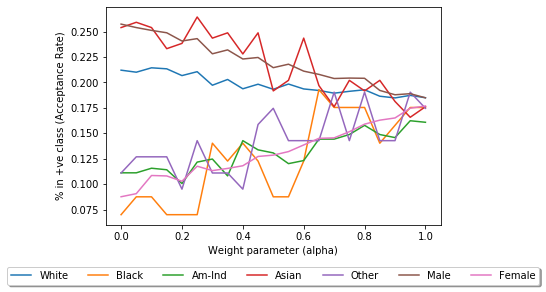

In [1]:
#beta =0.16>
import matplotlib.pyplot as plt
import numpy as np
x=[[0.21205579541680505 ,0.07017543859649122 ,0.11127819548872181 ,0.2538860103626943 ,0.1111111111111111 ,0.25728878484783996 ,0.08778791829639288],

[0.2100631019594819 ,0.08771929824561403 ,0.11127819548872181 ,0.25906735751295334 ,0.12698412698412698 ,0.25388380506490743 ,0.09083007388092133],

[0.21438060445034873 ,0.08771929824561403 ,0.11578947368421053 ,0.2538860103626943 ,0.12698412698412698 ,0.25111725899127474 ,0.10864841373315949],
[0.21338425772168715 ,0.07017543859649122 ,0.11428571428571428 ,0.23316062176165803 ,0.12698412698412698 ,0.2487763353905086 ,0.10821382007822686],

[0.20674194619727665 ,0.07017543859649122 ,0.10075187969924812 ,0.23834196891191708 ,0.09523809523809523 ,0.24068950840604383 ,0.10299869621903521],

[0.2105612753238127 ,0.07017543859649122 ,0.12180451127819548 ,0.26424870466321243 ,0.14285714285714285 ,0.24303043200680996 ,0.11777488048674489],

[0.1972766522749917 ,0.14035087719298245 ,0.12481203007518797 ,0.24352331606217617 ,0.1111111111111111 ,0.2281336454564801 ,0.11342894393741851],

[0.2029226170707406 ,0.12280701754385964 ,0.10827067669172932 ,0.24870466321243523 ,0.1111111111111111 ,0.23196424771227922 ,0.1156019122120817],

[0.1937894387246762 ,0.14035087719298245 ,0.14285714285714285 ,0.22797927461139897 ,0.09523809523809523 ,0.22302617578208128 ,0.11820947414167753],

[0.19827299900365328 ,0.12280701754385964 ,0.13383458646616542 ,0.24870466321243523 ,0.15873015873015872 ,0.22451585443711428 ,0.12733594089526293],

[0.1932912653603454 ,0.08771929824561403 ,0.13082706766917293 ,0.19170984455958548 ,0.1746031746031746 ,0.21451372632474994 ,0.12863972186006084],

[0.19843905679176355 ,0.08771929824561403 ,0.12030075187969924 ,0.20207253886010362 ,0.14285714285714285 ,0.2179187061076825 ,0.13211647109952196],

[0.19362338093656592 ,0.12280701754385964 ,0.12330827067669173 ,0.24352331606217617 ,0.14285714285714285 ,0.2111087465418174 ,0.13863537592351152],

[0.19212886084357356 ,0.19298245614035087 ,0.1443609022556391 ,0.19689119170984457 ,0.14285714285714285 ,0.20791657799531815 ,0.14515428074750109],

[0.18947193623380937 ,0.17543859649122806 ,0.1443609022556391 ,0.17616580310880828 ,0.19047619047619047 ,0.20387316450308576 ,0.14558887440243373],

[0.19129857190302224 ,0.17543859649122806 ,0.14887218045112782 ,0.20207253886010362 ,0.14285714285714285 ,0.20429878697595233 ,0.15167318557149065],
[0.1927930919960146 ,0.17543859649122806 ,0.15789473684210525 ,0.19170984455958548 ,0.19047619047619047 ,0.20408597573951906 ,0.1590612777053455],

[0.18648289604782464 ,0.14035087719298245 ,0.14887218045112782 ,0.20207253886010362 ,0.14285714285714285 ,0.19216854649925516 ,0.16297262059973924],

[0.184822318166722 ,0.15789473684210525 ,0.14586466165413534 ,0.18134715025906736 ,0.14285714285714285 ,0.18791232177058947 ,0.16514558887440242],

[0.18731318498837596 ,0.17543859649122806 ,0.162406015037594 ,0.16580310880829016 ,0.19047619047619047 ,0.1889763779527559 ,0.17470664928292046],

[0.18498837595483228 ,0.17543859649122806 ,0.16090225563909774 ,0.17616580310880828 ,0.1746031746031746 ,0.1849329644605235 ,0.17687961755758366],

[0.18498837595483228 ,0.17543859649122806 ,0.16090225563909774 ,0.17616580310880828 ,0.1746031746031746 ,0.1849329644605235 ,0.17687961755758366]]

a=[x[i][0] for i in range(21)]   
b=[x[i][1] for i in range(21)] 
c=[x[i][2] for i in range(21)]   
d=[x[i][3] for i in range(21)] 
e=[x[i][4] for i in range(21)]   
f=[x[i][5] for i in range(21)] 
g=[x[i][6] for i in range(21)]  
 


Discrepancy=np.arange(0,1.05,0.05)  
 
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(Discrepancy,a,label='White')   
ax.plot(Discrepancy,b,label='Black')  
ax.plot(Discrepancy,c,label='Am-Ind')  
ax.plot(Discrepancy,d,label='Asian')  
ax.plot(Discrepancy,e,label='Other')   
ax.plot(Discrepancy,f,label='Male')  
ax.plot(Discrepancy,g,label='Female') 



   
plt.title('')
ax.set_xlabel('Weight parameter (alpha)')
ax.set_ylabel('% in +ve class (Acceptance Rate)') 
# ax.set_ylabel('% in +ve class (Acceptance Rate)') 

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30), shadow=True, ncol=10)
plt.show() 


# plt.axis([0, 20, 0, 0.3])
# plt.xlabel('Weight parameter (alpha)')
# plt.ylabel('% in +ve class (Acceptance Rate)')

plt.show()


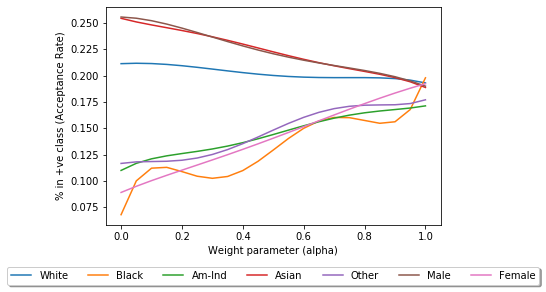

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
np.set_printoptions(precision=2)  # For compact display.
# x = np.array([2, 2, 5, 2, 1, 0, 1, 8, 15,13,7,2,0,9,15,6])
y1=savgol_filter(a, 21, 5)
y2=savgol_filter(b, 21, 5)
y3=savgol_filter(c, 21, 5)
y4=savgol_filter(d, 21, 5)
y5=savgol_filter(e, 21, 5)
y6=savgol_filter(f, 21, 5)
y7=savgol_filter(g, 21, 5)
# z=np.arange(0,16,1)
# plt.plot(Discrepancy,y1)
# plt.plot(Discrepancy,y2)
# plt.plot(Discrepancy,y3)
# plt.plot(Discrepancy,y4)
# plt.plot(Discrepancy,y5)
# plt.plot(Discrepancy,y6)
# plt.plot(Discrepancy,y7)
# # plt.plot(Discrepancy,b)
# plt.show()



fig = plt.figure()
ax = plt.subplot(111)
ax.plot(Discrepancy,y1,label='White')   
ax.plot(Discrepancy,y2,label='Black')  
ax.plot(Discrepancy,y3,label='Am-Ind')  
ax.plot(Discrepancy,y4,label='Asian')  
ax.plot(Discrepancy,y5,label='Other')   
ax.plot(Discrepancy,y6,label='Male')  
ax.plot(Discrepancy,y7,label='Female') 



   
plt.title('')
ax.set_xlabel('Weight parameter (alpha)')
ax.set_ylabel('% in +ve class (Acceptance Rate)') 
# ax.set_ylabel('% in +ve class (Acceptance Rate)') 

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30), shadow=True, ncol=10)
plt.show() 



# import numpy as np
# import matplotlib.pyplot as plt

# x = np.linspace(0,2*np.pi,100)
# y = np.sin(x) + np.random.random(100) * 0.2
# yhat = savitzky_golay(y, 51, 3) # window size 51, polynomial order 3

# plt.plot(x,y)
# plt.plot(x,yhat, color='red')
# plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

acc=[0.852, 0.845, 0.8344285714285714, 0.8267142857142857, 0.8167142857142857, 0.8062857142857143, 0.8, 0.787, 0.7792857142857142, 0.7687142857142857, 0.7587142857142857, 0.7484285714285714, 0.7428571428571429, 0.73, 0.7211428571428572, 0.706, 0.7037142857142857, 0.6958571428571428, 0.6885714285714286, 0.6767142857142857, 0.669]
DI=np.arange(0,1.05,0.05)

plt.axis([0, 1, 0.5, 1])
plt.xlabel('Weight parameter (alpha)')
plt.ylabel('Training Accuracy')

plt.title('')
 
plt.plot(DI,acc,color='black', linestyle='dashed', marker='.',
     markerfacecolor='black', markersize=12)   

# plt.legend([""])
plt.show() 


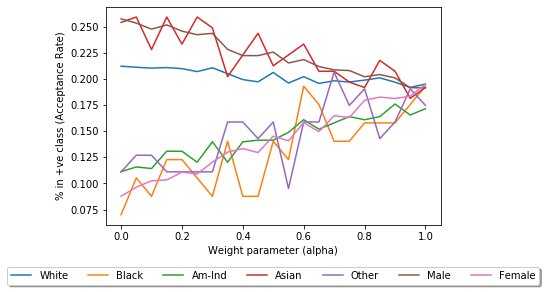

In [5]:
#beta>17
import matplotlib.pyplot as plt
import numpy as np
x=[[0.21205579541680505 ,0.07017543859649122 ,0.11127819548872181 ,0.2538860103626943 ,0.1111111111111111 ,0.25728878484783996 ,0.08778791829639288],

[0.21105944868814347 ,0.10526315789473684 ,0.11578947368421053 ,0.25906735751295334 ,0.12698412698412698 ,0.2532453713556076 ,0.09647979139504563],
[0.21022915974759215 ,0.08771929824561403 ,0.11428571428571428 ,0.22797927461139897 ,0.12698412698412698 ,0.24749946797190892 ,0.10256410256410256],
[0.21072733311192296 ,0.12280701754385964 ,0.13082706766917293 ,0.25906735751295334 ,0.1111111111111111 ,0.25154288146414133 ,0.10343328987396784
],

[0.20973098638326138 ,0.12280701754385964 ,0.13082706766917293 ,0.23316062176165803 ,0.1111111111111111 ,0.24558416684400936 ,0.11082138200782268
],
[0.20690800398538692 ,0.10526315789473684 ,0.12030075187969924 ,0.25906735751295334 ,0.1111111111111111 ,0.24217918706107683 ,0.10908300738809214
],
[0.2105612753238127 ,0.08771929824561403 ,0.13984962406015036 ,0.24870466321243523 ,0.1111111111111111 ,0.24345605447967653 ,0.12038244241634072
],
[0.20491531052806378 ,0.14035087719298245 ,0.12030075187969924 ,0.20207253886010362 ,0.15873015873015872 ,0.2281336454564801 ,0.12994350282485875
],
[0.19926934573231483 ,0.08771929824561403 ,0.13984962406015036 ,0.22279792746113988 ,0.15873015873015872 ,0.22217493083634815 ,0.13342025206431987
],
[0.19711059448688142 ,0.08771929824561403 ,0.14135338345864662 ,0.24352331606217617 ,0.14285714285714285 ,0.22217493083634815 ,0.1295089091699261
],
[0.2060777150448356 ,0.14035087719298245 ,0.14135338345864662 ,0.21243523316062177 ,0.15873015873015872 ,0.2255799106192807 ,0.14515428074750109
],
[0.1959481899701096 ,0.12280701754385964 ,0.14887218045112782 ,0.22279792746113988 ,0.09523809523809523 ,0.2151521600340498 ,0.1408083441981747
],
[0.20209232813018932 ,0.19298245614035087 ,0.16090225563909774 ,0.23316062176165803 ,0.15873015873015872 ,0.21834432858054906 ,0.15819209039548024
],
[0.19561607439388906 ,0.17543859649122806 ,0.1518796992481203 ,0.20725388601036268 ,0.15873015873015872 ,0.21174718025111725 ,0.14950021729682747
],
[0.198106941215543 ,0.14035087719298245 ,0.15789473684210525 ,0.20725388601036268 ,0.20634920634920634 ,0.20855501170461802 ,0.1647109952194698
],
[0.19694453669877118 ,0.14035087719298245 ,0.16390977443609023 ,0.19689119170984457 ,0.1746031746031746 ,0.20791657799531815 ,0.16297262059973924
],
[0.19877117236798406 ,0.15789473684210525 ,0.16090225563909774 ,0.19170984455958548 ,0.19047619047619047 ,0.2019578633751862 ,0.1794871794871795
],
[0.20092992361341747 ,0.15789473684210525 ,0.16390977443609023 ,0.21761658031088082 ,0.14285714285714285 ,0.20408597573951906 ,0.18252933507170796
],
[0.19677847891066091 ,0.15789473684210525 ,0.17593984962406015 ,0.20725388601036268 ,0.15873015873015872 ,0.2008938071930198 ,0.18122555410691005
],
[0.19179674526735305 ,0.17543859649122806 ,0.16541353383458646 ,0.18134715025906736 ,0.19047619047619047 ,0.1915301127899553 ,0.18339852238157323
],
[0.19495184324144801 ,0.19298245614035087 ,0.17142857142857143 ,0.19170984455958548 ,0.1746031746031746 ,0.19131730155352203 ,0.19469795740982182
],
[0.19495184324144801 ,0.19298245614035087 ,0.17142857142857143 ,0.19170984455958548 ,0.1746031746031746 ,0.19131730155352203 ,0.19469795740982182]]


a=[x[i][0] for i in range(21)]   
b=[x[i][1] for i in range(21)] 
c=[x[i][2] for i in range(21)]   
d=[x[i][3] for i in range(21)] 
e=[x[i][4] for i in range(21)]   
f=[x[i][5] for i in range(21)] 
g=[x[i][6] for i in range(21)]  
 


Discrepancy=np.arange(0,1.05,0.05)  
 
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(Discrepancy,a,label='White')   
ax.plot(Discrepancy,b,label='Black')  
ax.plot(Discrepancy,c,label='Am-Ind')  
ax.plot(Discrepancy,d,label='Asian')  
ax.plot(Discrepancy,e,label='Other')   
ax.plot(Discrepancy,f,label='Male')  
ax.plot(Discrepancy,g,label='Female') 

#white   black    americanindian   asian         other   male       female

#male asian white americnindian other black female

   
plt.title('')
ax.set_xlabel('Weight parameter (alpha)')
ax.set_ylabel('% in +ve class (Acceptance Rate)') 
# ax.set_ylabel('% in +ve class (Acceptance Rate)') 

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30), shadow=True, ncol=10)
plt.show() 


# plt.axis([0, 20, 0, 0.3])
# plt.xlabel('Weight parameter (alpha)')
# plt.ylabel('% in +ve class (Acceptance Rate)')

plt.show()

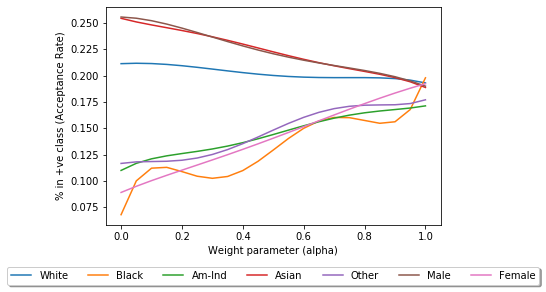

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
np.set_printoptions(precision=2)  # For compact display.
# x = np.array([2, 2, 5, 2, 1, 0, 1, 8, 15,13,7,2,0,9,15,6])
y1=savgol_filter(a, 21, 5)
y2=savgol_filter(b, 21, 5)
y3=savgol_filter(c, 21, 5)
y4=savgol_filter(d, 21, 5)
y5=savgol_filter(e, 21, 5)
y6=savgol_filter(f, 21, 5)
y7=savgol_filter(g, 21, 5)
# z=np.arange(0,16,1)

# plt.plot(Discrepancy,b)




fig = plt.figure()
ax = plt.subplot(111)
ax.plot(Discrepancy,y1,label='White')   
ax.plot(Discrepancy,y2,label='Black')  
ax.plot(Discrepancy,y3,label='Am-Ind')  
ax.plot(Discrepancy,y4,label='Asian')  
ax.plot(Discrepancy,y5,label='Other')   
ax.plot(Discrepancy,y6,label='Male')  
ax.plot(Discrepancy,y7,label='Female') 



   
plt.title('')
ax.set_xlabel('Weight parameter (alpha)')
ax.set_ylabel('% in +ve class (Acceptance Rate)') 
# ax.set_ylabel('% in +ve class (Acceptance Rate)') 

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30), shadow=True, ncol=10)
plt.show() 



# import numpy as np
# import matplotlib.pyplot as plt

# x = np.linspace(0,2*np.pi,100)
# y = np.sin(x) + np.random.random(100) * 0.2
# yhat = savitzky_golay(y, 51, 3) # window size 51, polynomial order 3

# plt.plot(x,y)
# plt.plot(x,yhat, color='red')
# plt.show()

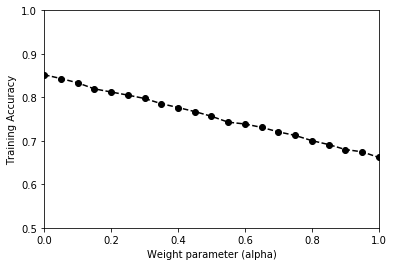

In [7]:
import matplotlib.pyplot as plt
import numpy as np
acc=[0.852, 0.8432857142857143, 0.8334285714285714, 0.8195714285714286, 0.8122857142857143, 0.8051428571428572, 0.7974285714285714, 0.7854285714285715, 0.7765714285714286, 0.7672857142857142, 0.7564285714285715, 0.7428571428571429, 0.7387142857142858, 0.7308571428571429, 0.7205714285714285, 0.7124285714285714, 0.7004285714285714, 0.6914285714285714, 0.68, 0.6747142857142857, 0.6617142857142857]
DI=np.arange(0,1.05,0.05)
plt.axis([0, 1, 0.5, 1])
plt.xlabel('Weight parameter (alpha)')
plt.ylabel('Training Accuracy')

plt.title('')
 
plt.plot(DI,acc,color='black', linestyle='dashed', marker='.',
     markerfacecolor='black', markersize=12)   

# plt.legend([""])
plt.show() 

In [9]:
#Solving gerimendering issue
######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT ALL SENS MIN Max COMMAND----###################### 
import time
import pandas as pd
import numpy as np
filename = '../input/2adult.csv'
d1 = pd.read_csv(filename)
chosen_idx = np.random.choice(d1.shape[0], replace = False, size = int(1*d1.shape[0])) 
k=d1.shape[1] 

d2 = d1.iloc[chosen_idx,0:k] 

m=d2.shape[1]
n=d2.shape[0]
x0=d2.iloc[0:n,0]   #/* age--> data-0 1*/
x1 = d2.iloc[0:n,8] #//race---> data- white am_islander asian-amer others black
x2 = d2.iloc[0:n,9] #//sex---> data- male female
x3 = d2.iloc[0:n,12]#// h_w--->data   >35 <=35
x4 = d2.iloc[0:n,13]#//country--->data us not_us
y=d2.iloc[0:n,14]

# print(x1)
# print(x2)
# print(y)

        
r = np.zeros(n, dtype = int)         
for i in range(n):
    if y.iloc[i]==' <=50K'or y.iloc[i]==' <=50K.':
        r[i]=-1
    else :
        r[i]= 1    
        
data = np.zeros((13, n), dtype = int)

a=0
b=0
c=0
d=0
e=0
f=0
g=0
h=0
ii=0
jj=0
k=0
l=0
mm=0
acc0=0
acc1=0
acc2=0
acc3=0
acc4=0
acc5=0
acc6=0
acc7=0
acc8=0
acc9=0
acc10=0
acc11=0
acc12=0

for i in range(n):
        if x0.iloc[i] >45:
            data[0][i]= 1
            a=a+1
            if r[i]==1:
                acc0=acc0+1
        else:
            data[1][i]= 1
            b=b+1
            if r[i]==1:
                acc1=acc1+1
    
        if x1.iloc[i] == ' White':
            data[2][i]= 1
            c=c+1
            if r[i]==1:
                acc2=acc2+1
        elif x1.iloc[i] == ' Asian-Pac-Islander':
            data[3][i]= 1
            d=d+1
            if r[i]==1:
                acc3=acc3+1
        elif x1.iloc[i] == ' Amer-Indian-Eskimo':
            data[4][i]= 1
            e=e+1
            if r[i]==1:
                acc4=acc4+1
        elif x1.iloc[i] == ' Other':
            data[5][i]= 1
            f=f+1
            if r[i]==1:
                acc5=acc5+1
        elif x1.iloc[i] == ' Black':
            data[6][i]= 1
            g=g+1
            if r[i]==1:
                acc6=acc6+1

        if x2.iloc[i] == ' Male':
            data[7][i]= 1
            h=h+1
            if r[i]==1:
                acc7=acc7+1
        elif x2.iloc[i]==' Female':
            data[8][i]= 1
            ii=ii+1
            if r[i]==1:
                acc8=acc8+1 
        if x3.iloc[i]>35:
            data[9][i]= 1
            jj=jj+1
            if r[i]==1:
                acc9=acc9+1
        else:
            data[10][i]= 1
            k=k+1
            if r[i]==1:
                acc10=acc10+1   
        
        if x4.iloc[i] == ' United-States':
            data[11][i]= 1
            l=l+1
            if r[i]==1:
                acc11=acc11+1
        else:
            data[12][i]= 1
            mm=mm+1
            if r[i]==1:
                acc12=acc12+1   
            

a1=float(acc0/a)
b1=float(acc1/b)
c1=float(acc2/c)
d1=float(acc3/d)
e1=float(acc4/e)
f1=float(acc5/f)
g1=float(acc6/g)
h1=float(acc7/h)
i1=float(acc8/ii)
j1=float(acc9/jj)
k1=float(acc10/k)
l1=float(acc11/l)
m1=float(acc12/mm)

print(a,b,c,d,e,f,g,h,ii,jj,k,l,mm)              
print(acc0,acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8,acc9,acc10,acc11,acc12)
print(a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1)

#input sets of satisfying_groups
# input 5--in1 in2 in3 in4

# take input from user 

# print(type(i1)) 

# print('choose: age 1.>45   2.<=45')

# print('choose: race 1.white 2.am_islander 3.asian-amer 4.others 5.black')

# print('choose: sex  1.male 2.female')

# print('choose: h_w  1.>35 2.<=35')

# print('choose: country 1.us 2.not_us')

      
#       F american
#       F black <=35
#       M black american 
#       M black age>45 w_h>35
#       F american age<=45 wh>35
datax= np.zeros((5,n), dtype = int)  
group0=0
group1=1
group2=2
group3=3
group4=4
count0=0
count1=0
count2=0
count3=0
count4=0
      
for i in range(n):    
    if(data[8][i]==1 and data[11][i]==1):    
        datax[group0][i]=1
        count0=count0+1
    if(data[8][i]==1 and data[10][i]==1 and data[11][i]==1):
        datax[group1][i]=1
        count1=count1+1
    if(data[7][i]==1 and data[6][i]==1 and data[11][i]==1 ):
        datax[group2][i]=1
        count2=count2+1
    if(data[7][i]==1 and data[6][i]==1 and data[0][i]==1 and data[9][i]==1 ):
        datax[group3][i]=1
        count3=count3+1
    if(data[8][i]==1 and data[11][i]==1 and data[1][i]==1 and data[9][i]==1 ):
        datax[group4][i]=1
        count4=count4+1
        
# for i in range(n):
#     print("gender:")
#     in1=
#     if(data[i][0]==1 ):
            
# for j in range(satisfying_groups):
#       for i in range(n):
#              if(data[i][0]==1 ):


##########################################

maxi=0
acc1_l=[]
acc2_l=[]
epsilon_l=[]

feld_di_arr1=[]
zafar_di_arr1=[]
   
feld_di_arr2=[]
zafar_di_arr2=[]  


# for gamma in np.arange(0.15,0.5,.05):
#     for eps in np.arange(0.05,0.02,-.01): 
gamma=0.16
eps=0.00
acc0=0
acc1=0
acc2=0
acc3=0
acc4=0

u1,u2=min_max_lp_all(datax,gamma,eps,r)
# print("--- %s seconds ---" % (time.time() - start_time))
#######################Disp_impact#######################  



for i in range(n):
    if datax[0][i]== 1 and u1[i]==1:
            acc0=acc0+1
    if datax[1][i]== 1 and u1[i]==1:
            acc1=acc1+1  
    if datax[2][i]== 1 and u1[i]==1:
            acc2=acc2+1 
    if datax[3][i]== 1 and u1[i]==1:
            acc3=acc3+1         
    if datax[4][i]== 1 and u1[i]==1:
            acc4=acc4+1 
             


a1=float(acc0/count0)
b1=float(acc1/count1)
c1=float(acc2/count2)
d1=float(acc3/count3)
e1=float(acc4/count4)

print(count0,count1,count2,count3,count4)              
print(acc0,acc1,acc2,acc3,acc4)

print(a1,b1,c1,d1,e1)

#         DI1_zafar1=abs(float(b1-a1))



#         feld_di_arr1.append(DI1_feld1)
#         zafar_di_arr1.append(DI1_zafar1)

#     print('w.r.t race Disperate impact ---field--- zafar')
#     print(DI1_feld1,DI1_zafar1)




#         DI1_feld2=abs(float(b1/a1))
#         DI1_zafar2=abs(float(b1-a1))



#         feld_di_arr2.append(DI1_feld2)
#         zafar_di_arr2.append(DI1_zafar2)

#         print('w.r.t gender Disperate impact ---field--- zafar')
#         print(DI1_feld2,DI1_zafar2)

count1=0
count2=0
for j in range(r.shape[0]):
        if(r[j]==u1[j]):
            count1+=1
acc1=float(count1/r.shape[0])        

for j in range(r.shape[0]):
        if(r[j]==u2[j]):
            count2+=1
acc2=float(count2/r.shape[0]) 
# print(acc1)
# print(acc2)
print(gamma)
print(eps)
#     epsilon_l.append(eps)
acc2_l.append(acc2)
acc1_l.append(acc1)

    
print("Accuracy::")    
print(acc1_l)     
print(acc2_l)


# print("Disparate Impact w.r.t race")
# print(feld_di_arr1)
# print(zafar_di_arr1)

# print("Disparate Impact w.r.t gender")
# print(feld_di_arr2)
# print(zafar_di_arr2)

# print(epsilon_l)
# 0.35964424710491644 0.19452504999275444


9627 22933 27815 1039 311 271 3124 21789 10771 25680 6880 29169 3391
3362 4479 7117 276 36 25 387 6662 1179 7259 582 7171 670
0.3492261348291264 0.1953080713382462 0.25586913535861944 0.26564003849855633 0.1157556270096463 0.09225092250922509 0.12387964148527529 0.3057506081050071 0.10946058861758426 0.2826713395638629 0.08459302325581396 0.24584318968768212 0.19758183426717782
dimension of data
5 32560
Undefined
discripency is:
6583.76
9682 3261 1403 369 4691
1547 521 224 59 750
0.15978103697583143 0.1597669426556271 0.15965787598004277 0.15989159891598917 0.1598806224685568
0.16
0.0
Accuracy::
[0.7183046683046683]
[0.2816953316953317]


In [8]:

######################NILOY_Sir gamma/!w! +-epsilon<

############################---LP4-with controling discripancy accord. to sens attribute set-########################
#############---- ADULT gender sens 1 in 1 row MIN Max COMMAND----###################### 
import time
import pulp as p 
def min_max_lp_all(data1,gamma,eps,r):
#     x1=data1
#     x2=np.logical_not(x1).astype(int)
#     data1=np.append(x1,x2,axis=0)
#   R = np.zeros((2, n), dtype = int)
#     for i in range(n):
#         if x1[i]== 1:
#             R[0][i]= 1
#         else:
    
    
    m=data1.shape[0]
    n=data1.shape[1]
    print('dimension of data')
    print(m,n)
    Lp_prob = p.LpProblem('Problem', p.LpMinimize)  
   
    #X[n]=z() n last value of X
    #X=np.zeros(n+2,dtype=p.LpVariable)
    X=np.zeros(n+1,dtype=p.LpVariable)
    sizes=np.zeros(m,dtype=int)
    for i in range(m):
        count=0
        for j in range(n):
            if data1[i][j]==1:
                count=count+1
                
        sizes[i]=count
    #X[]=0 to n-1

    for i in range(n):
        var1=str(i)
        
        X[i]=p.LpVariable(var1,lowBound=0,upBound=1,cat='Integer')
       
        
    X[n] =  p.LpVariable("z1",lowBound=0)
    #X[n+1] =  p.LpVariable("z2",lowBound=0)

    #########objective function#####################
    Lp_prob += X[n]
#     Lp_prob += X[n] +X[n+1]

    ##############constraint#################
    for i in range(2*m):
        if i<m:
            Lp_prob += X[n] >= p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)])
            Lp_prob += p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)]) >= (2*gamma-1)*sizes[i]
            Lp_prob += p.lpSum([2*(X[j]-0.5)*data1[i][j] for j in range(n)]) <= ((2*gamma-1)+eps)*sizes[i]
            
        else:        
            Lp_prob += X[n] >= p.lpSum([-1*2*(X[j]-0.5)*data1[i-m][j] for j in range(n)])
            
         
    ##### r(y_train values real labels of data)
#     Lp_prob += X[n+1] >= p.lpSum([2*(X[j]-0.5)-r[j] for j in range(n)])
#     Lp_prob += X[n+1] >= p.lpSum([-1*2*(X[j]-0.5)+r[j] for j in range(n)])
        
#     epsilon=.01
    #n1 is the number of elements in sensitive attribute 
           
       
    Lp_prob += X[n] <= 42000
    
    #####################################
    status = Lp_prob.solve()   # Solver 
    print(p.LpStatus[status]) 
    print("discripency is:")        
    print(p.value(Lp_prob.objective))
    x=np.zeros(n,dtype=float)
#     for i in range(n):
#         x[i]=p.value(X[i])
#     for i in range(n):
#         print(x)
   # The solution status 
    Synth1={}
    Synth2={}
    # # Printing the final solution 
    for i in range(n):
        if(p.value(X[i])==1):
            Synth1[i]=1 
            Synth2[i]=-1
        else:
            Synth1[i]=-1
            Synth2[i]=1
    Synthu1=Synth1  
    Synthu2=Synth2  
    
              
    return Synthu1,Synthu2   
